# Рекомендация банковских продуктов — Исследовательский анализ данных (EDA)

**Задача:** предсказать, какие новые банковские продукты клиент подключит в следующем месяце.

**Данные:** ежемесячные срезы клиентов банка (~13.6 млн строк, 48 колонок, период янв 2015 — июн 2016).

**Содержание:**
1. Загрузка данных с оптимизацией памяти
2. Общий обзор
3. Анализ пропусков
4. Очистка данных
5. Распределения клиентских признаков
6. Анализ продуктов
7. Корреляции между продуктами
8. Клиентские сегменты vs продукты
9. Временной анализ
10. Выводы и рекомендации для моделирования

## 0. Импорты и константы

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

RANDOM_STATE = 42

PRODUCT_COLS = [
    'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
    'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
    'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
    'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
    'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
    'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
    'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
    'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1'
]

PRODUCT_NAMES = {
    'ind_ahor_fin_ult1': 'Сберегательный счёт',
    'ind_aval_fin_ult1': 'Банковская гарантия',
    'ind_cco_fin_ult1': 'Текущие счета',
    'ind_cder_fin_ult1': 'Деривативный счёт',
    'ind_cno_fin_ult1': 'Зарплатный проект',
    'ind_ctju_fin_ult1': 'Детский счёт',
    'ind_ctma_fin_ult1': 'Особый счёт 3',
    'ind_ctop_fin_ult1': 'Особый счёт',
    'ind_ctpp_fin_ult1': 'Особый счёт 2',
    'ind_deco_fin_ult1': 'Краткосрочный депозит',
    'ind_deme_fin_ult1': 'Среднесрочный депозит',
    'ind_dela_fin_ult1': 'Долгосрочный депозит',
    'ind_ecue_fin_ult1': 'Цифровой счёт',
    'ind_fond_fin_ult1': 'Денежные средства',
    'ind_hip_fin_ult1': 'Ипотека',
    'ind_plan_fin_ult1': 'Пенсионный план',
    'ind_pres_fin_ult1': 'Кредит',
    'ind_reca_fin_ult1': 'Налоговый счёт',
    'ind_tjcr_fin_ult1': 'Кредитная карта',
    'ind_valo_fin_ult1': 'Ценные бумаги',
    'ind_viv_fin_ult1': 'Домашний счёт',
    'ind_nomina_ult1': 'Зарплатный аккаунт',
    'ind_nom_pens_ult1': 'Пенсионный аккаунт',
    'ind_recibo_ult1': 'Дебетовый аккаунт'
}

# Колонки для удаления (бесполезные)
DROP_COLS = ['conyuemp', 'ult_fec_cli_1t', 'tipodom']

## 1. Загрузка данных с оптимизацией памяти

Файл `train_ver2.csv` весит ~2.1 ГБ. Используем указание типов (`dtype`) для экономии оперативной памяти.

In [2]:
dtype_dict = {
    'ncodpers': np.int32,
    'ind_empleado': 'category',
    'pais_residencia': 'category',
    'sexo': 'category',
    'ind_nuevo': np.float32,
    'indrel': np.float32,
    'indrel_1mes': 'category',
    'tiprel_1mes': 'category',
    'indresi': 'category',
    'indext': 'category',
    'conyuemp': 'category',
    'canal_entrada': 'category',
    'indfall': 'category',
    'cod_prov': np.float32,
    'nomprov': 'category',
    'ind_actividad_cliente': np.float32,
    'renta': np.float64,
    'segmento': 'category',
}

# Продуктовые колонки — int8 (но в CSV есть NaN в nomina/nom_pens, поэтому float)
for col in PRODUCT_COLS:
    dtype_dict[col] = np.float32

df = pd.read_csv(
    '../train_ver2.csv',
    dtype=dtype_dict,
    parse_dates=['fecha_dato', 'fecha_alta'],
)

print(f'Загружено: {df.shape[0]:,} строк, {df.shape[1]} колонок')
print(f'Использование памяти: {df.memory_usage(deep=True).sum() / 1e9:.2f} ГБ')

Загружено: 13,647,309 строк, 48 колонок


Использование памяти: 3.75 ГБ


## 2. Общий обзор

In [3]:
print('Форма датасета:', df.shape)
print(f'Уникальных клиентов: {df["ncodpers"].nunique():,}')
print(f'Период: {df["fecha_dato"].min().date()} — {df["fecha_dato"].max().date()}')
print(f'Количество месяцев: {df["fecha_dato"].nunique()}')

Форма датасета: (13647309, 48)
Уникальных клиентов: 956,645
Период: 2015-01-28 — 2016-05-28


Количество месяцев: 17


In [4]:
df.head(3)

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df.dtypes

fecha_dato               datetime64[ns]
ncodpers                          int32
ind_empleado                   category
pais_residencia                category
sexo                           category
age                              object
fecha_alta               datetime64[ns]
ind_nuevo                       float32
antiguedad                       object
indrel                          float32
ult_fec_cli_1t                   object
indrel_1mes                    category
tiprel_1mes                    category
indresi                        category
indext                         category
conyuemp                       category
canal_entrada                  category
indfall                        category
tipodom                         float64
cod_prov                        float32
nomprov                        category
ind_actividad_cliente           float32
renta                           float64
segmento                       category
ind_ahor_fin_ult1               float32


In [6]:
df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
fecha_dato,13647309,NaN,NaN,NaN,2015-10-19 22:37:34.242196736,2015-01-28 00:00:00,2015-06-28 00:00:00,2015-10-28 00:00:00,2016-02-28 00:00:00,2016-05-28 00:00:00,NaN
ncodpers,13647309.0,NaN,NaN,NaN,834904.211501,15889.0,452813.0,931893.0,1199286.0,1553689.0,431565.025784
ind_empleado,13619575,5,N,13610977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pais_residencia,13619575,118,ES,13553710,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sexo,13619505,2,V,7424252,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,13647309.0,235.0,23.0,542682.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fecha_alta,13619575,NaN,NaN,NaN,2009-02-09 01:23:15.306534912,1995-01-16 00:00:00,2004-04-23 00:00:00,2011-09-01 00:00:00,2013-10-18 00:00:00,2016-05-31 00:00:00,NaN
ind_nuevo,13619575.0,NaN,NaN,NaN,0.059562,0.0,0.0,0.0,0.0,1.0,0.236673
antiguedad,13647309.0,507.0,0.0,134335.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
indrel,13619575.0,NaN,NaN,NaN,1.178399,1.0,1.0,1.0,1.0,99.0,4.177469


In [7]:
# Количество записей по месяцам
month_counts = df.groupby('fecha_dato').size().reset_index(name='count')
month_counts['fecha_dato'] = month_counts['fecha_dato'].dt.strftime('%Y-%m')
print('Записей по месяцам:')
month_counts

Записей по месяцам:


,fecha_dato,count
0,2015-01,625457
1,2015-02,627394
2,2015-03,629209
3,2015-04,630367
4,2015-05,631957
5,2015-06,632110
6,2015-07,829817
7,2015-08,843201
8,2015-09,865440
9,2015-10,892251


## 3. Анализ пропусков

In [8]:
# Таблица пропусков
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Пропуски': missing,
    '% пропусков': missing_pct
}).sort_values('Пропуски', ascending=False)

missing_df[missing_df['Пропуски'] > 0]

,Пропуски,% пропусков
conyuemp,13645501,99.99
ult_fec_cli_1t,13622516,99.82
renta,2794375,20.48
segmento,189368,1.39
canal_entrada,186126,1.36
indrel_1mes,149781,1.10
tiprel_1mes,149781,1.10
nomprov,93591,0.69
cod_prov,93591,0.69
sexo,27804,0.20


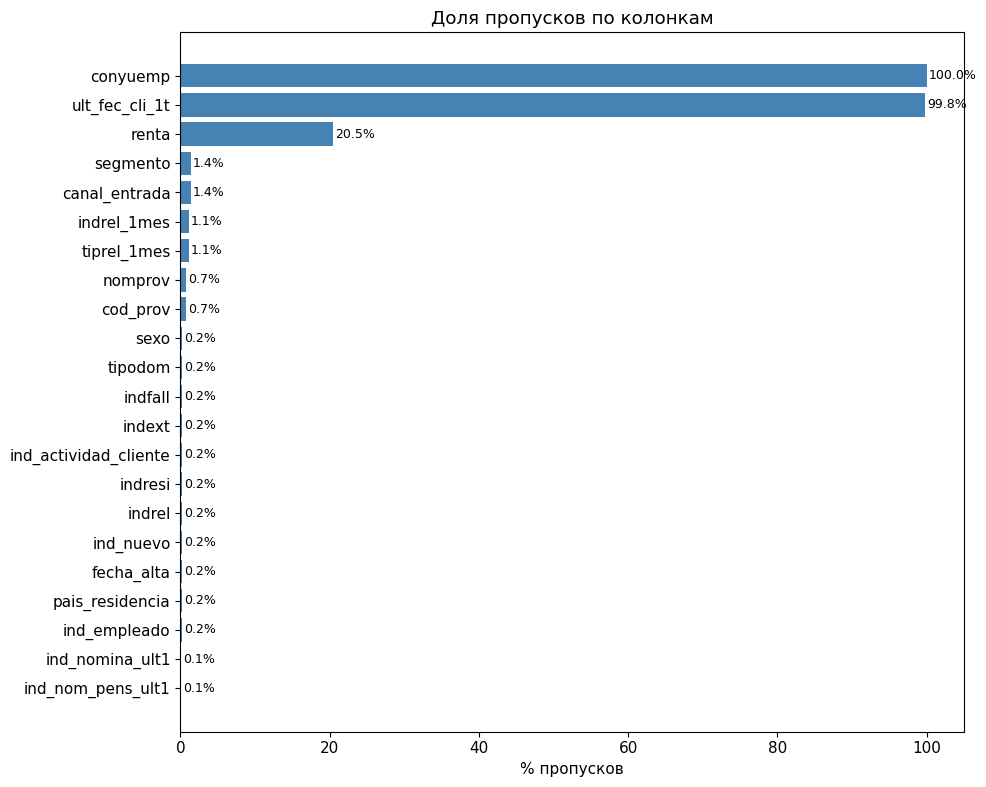

In [9]:
# Визуализация пропусков
cols_with_missing = missing_df[missing_df['Пропуски'] > 0].sort_values('% пропусков', ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(cols_with_missing.index, cols_with_missing['% пропусков'], color='steelblue')
ax.set_xlabel('% пропусков')
ax.set_title('Доля пропусков по колонкам')
for i, v in enumerate(cols_with_missing['% пропусков']):
    ax.text(v + 0.3, i, f'{v:.1f}%', va='center', fontsize=9)
plt.tight_layout()
plt.show()

In [10]:
# Детекция полностью битых строк (NaN во всех ключевых метаданных)
metadata_cols = ['ind_empleado', 'pais_residencia', 'sexo', 'age',
                 'ind_nuevo', 'antiguedad', 'indrel', 'tiprel_1mes',
                 'indresi', 'indext', 'canal_entrada', 'indfall',
                 'ind_actividad_cliente', 'segmento']

# age и antiguedad — строковые, проверяем на NA/NaN через isnull после преобразования
broken_mask = df[['ind_empleado', 'pais_residencia', 'sexo',
                   'ind_nuevo', 'indrel', 'tiprel_1mes',
                   'indresi', 'indext', 'canal_entrada', 'indfall',
                   'ind_actividad_cliente', 'segmento']].isnull().all(axis=1)

n_broken = broken_mask.sum()
print(f'Полностью битые строки (NaN во всех метаданных): {n_broken}')
if n_broken > 0:
    print('Примеры:')
    display(df[broken_mask].head(3))

Полностью битые строки (NaN во всех метаданных): 27734
Примеры:


,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
261,2015-01-28,1050741,NaN,NaN,NaN,NA,NaT,NaN,NA,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1029,2015-01-28,1051017,NaN,NaN,NaN,NA,NaT,NaN,NA,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1063,2015-01-28,1051064,NaN,NaN,NaN,NA,NaT,NaN,NA,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Стратегии обработки пропусков
strategies = pd.DataFrame({
    'Колонка': ['conyuemp', 'ult_fec_cli_1t', 'tipodom',
                'renta', 'cod_prov', 'nomprov', 'canal_entrada',
                'segmento', 'ind_nuevo', 'indrel_1mes', 'tiprel_1mes',
                'ind_nomina_ult1', 'ind_nom_pens_ult1',
                'sexo', 'ind_empleado', 'ind_actividad_cliente', 'indrel',
                'age', 'antiguedad', 'indresi', 'indext', 'indfall'],
    '% пропусков': [
        missing_pct.get('conyuemp', 0), missing_pct.get('ult_fec_cli_1t', 0),
        missing_pct.get('tipodom', 0),
        missing_pct.get('renta', 0), missing_pct.get('cod_prov', 0),
        missing_pct.get('nomprov', 0), missing_pct.get('canal_entrada', 0),
        missing_pct.get('segmento', 0), missing_pct.get('ind_nuevo', 0),
        missing_pct.get('indrel_1mes', 0), missing_pct.get('tiprel_1mes', 0),
        missing_pct.get('ind_nomina_ult1', 0), missing_pct.get('ind_nom_pens_ult1', 0),
        missing_pct.get('sexo', 0), missing_pct.get('ind_empleado', 0),
        missing_pct.get('ind_actividad_cliente', 0), missing_pct.get('indrel', 0),
        missing_pct.get('age', 0), missing_pct.get('antiguedad', 0),
        missing_pct.get('indresi', 0), missing_pct.get('indext', 0),
        missing_pct.get('indfall', 0)
    ],
    'Стратегия': [
        'Удалить (100% NaN)', 'Удалить (99.9% NaN)', 'Удалить (константа=1)',
        'Заполнить медианой по сегменту/провинции', 'Заполнить модой / оставить NaN',
        'Заполнить модой / оставить NaN', 'Заполнить модой',
        'Заполнить модой', 'Заполнить 0', 'Заполнить модой', 'Заполнить модой',
        'Заполнить 0 (нет продукта)', 'Заполнить 0 (нет продукта)',
        'Заполнить модой', 'Заполнить модой',
        'Заполнить модой', 'Заполнить модой',
        'Очистить строку → to_numeric → заполнить медианой',
        'Очистить строку → to_numeric → заполнить медианой',
        'Заполнить модой', 'Заполнить модой', 'Заполнить модой'
    ]
})
strategies = strategies.sort_values('% пропусков', ascending=False)
strategies[strategies['% пропусков'] > 0]

,Колонка,% пропусков,Стратегия
0,conyuemp,99.99,Удалить (100% NaN)
1,ult_fec_cli_1t,99.82,Удалить (99.9% NaN)
3,renta,20.48,Заполнить медианой по сегменту/провинции
7,segmento,1.39,Заполнить модой
6,canal_entrada,1.36,Заполнить модой
9,indrel_1mes,1.10,Заполнить модой
10,tiprel_1mes,1.10,Заполнить модой
4,cod_prov,0.69,Заполнить модой / оставить NaN
5,nomprov,0.69,Заполнить модой / оставить NaN
14,ind_empleado,0.20,Заполнить модой


## 4. Очистка данных

Минимальная очистка для EDA: удаление бесполезных колонок, битых строк, приведение типов.

In [12]:
print(f'Строк до очистки: {len(df):,}')

# Удаление бесполезных колонок
df.drop(columns=DROP_COLS, inplace=True)
print(f'Удалены колонки: {DROP_COLS}')

# Удаление полностью битых строк
df = df[~broken_mask].copy()
print(f'Удалено битых строк: {n_broken}')
print(f'Строк после: {len(df):,}')

Строк до очистки: 13,647,309


Удалены колонки: ['conyuemp', 'ult_fec_cli_1t', 'tipodom']


Удалено битых строк: 27734
Строк после: 13,619,575


In [13]:
# Очистка age: strip пробелов → to_numeric
df['age'] = pd.to_numeric(df['age'].astype(str).str.strip(), errors='coerce').astype(np.float32)

print(f'age: min={df["age"].min()}, max={df["age"].max()}, median={df["age"].median()}')
print(f'age NaN после очистки: {df["age"].isnull().sum()}')

age: min=2.0, max=164.0, median=39.0
age NaN после очистки: 0


In [14]:
# Очистка antiguedad: strip пробелов → to_numeric
df['antiguedad'] = pd.to_numeric(
    df['antiguedad'].astype(str).str.strip(), errors='coerce'
).astype(np.float32)

print(f'antiguedad: min={df["antiguedad"].min()}, max={df["antiguedad"].max()}, '
      f'median={df["antiguedad"].median()}')
print(f'antiguedad NaN после очистки: {df["antiguedad"].isnull().sum()}')

antiguedad: min=-999999.0, max=256.0, median=50.0
antiguedad NaN после очистки: 0


In [15]:
# Заполнение NaN в продуктовых колонках nomina/nom_pens → 0
for col in ['ind_nomina_ult1', 'ind_nom_pens_ult1']:
    n_null = df[col].isnull().sum()
    df[col] = df[col].fillna(0).astype(np.int8)
    print(f'{col}: заполнено {n_null:,} NaN нулями')

# Конвертируем все продуктовые колонки в int8
for col in PRODUCT_COLS:
    df[col] = df[col].fillna(0).astype(np.int8)

ind_nomina_ult1: заполнено 217 NaN нулями
ind_nom_pens_ult1: заполнено 217 NaN нулями


In [16]:
# Инспекция аномалий возраста
underage = df[df['age'] < 18]
over100 = df[df['age'] > 100]
print(f'Записей с возрастом < 18: {len(underage):,} '
      f'({len(underage)/len(df)*100:.3f}%)')
print(f'Записей с возрастом > 100: {len(over100):,} '
      f'({len(over100)/len(df)*100:.3f}%)')

if len(underage) > 0:
    print(f'\nНесовершеннолетние: age min={underage["age"].min()}, '
          f'распределение:')
    print(underage['age'].value_counts().sort_index().head(10))

Записей с возрастом < 18: 118,796 (0.872%)
Записей с возрастом > 100: 12,869 (0.094%)

Несовершеннолетние: age min=2.0, распределение:
age
2.0       733
3.0      1534
4.0      2210
5.0      3004
6.0      3673
7.0      3792
8.0      4744
9.0      5887
10.0     7950
11.0    10481
Name: count, dtype: int64


In [17]:
# Итоговое использование памяти
mem_gb = df.memory_usage(deep=True).sum() / 1e9
print(f'Использование памяти после очистки: {mem_gb:.2f} ГБ')
print(f'Форма: {df.shape}')

Использование памяти после очистки: 1.31 ГБ
Форма: (13619575, 45)


## 5. Распределения клиентских признаков

Берём срез за последний доступный месяц для кросс-секционного анализа.

In [18]:
last_month = df['fecha_dato'].max()
print(f'Последний месяц: {last_month.date()}')

snap = df[df['fecha_dato'] == last_month].copy()
print(f'Клиентов в последнем месяце: {len(snap):,}')

Последний месяц: 2016-05-28


Клиентов в последнем месяце: 931,453


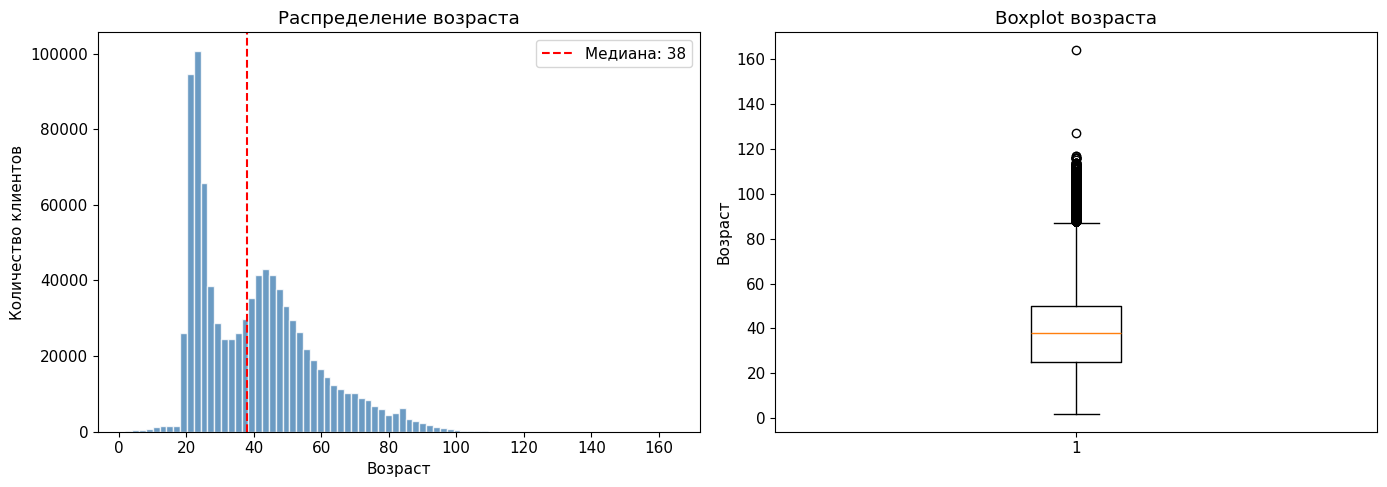

In [19]:
# Возраст: гистограмма + boxplot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(snap['age'].dropna(), bins=80, color='steelblue', edgecolor='white', alpha=0.8)
axes[0].set_xlabel('Возраст')
axes[0].set_ylabel('Количество клиентов')
axes[0].set_title('Распределение возраста')
axes[0].axvline(snap['age'].median(), color='red', linestyle='--', label=f'Медиана: {snap["age"].median():.0f}')
axes[0].legend()

axes[1].boxplot(snap['age'].dropna(), vert=True)
axes[1].set_ylabel('Возраст')
axes[1].set_title('Boxplot возраста')

plt.tight_layout()
plt.show()

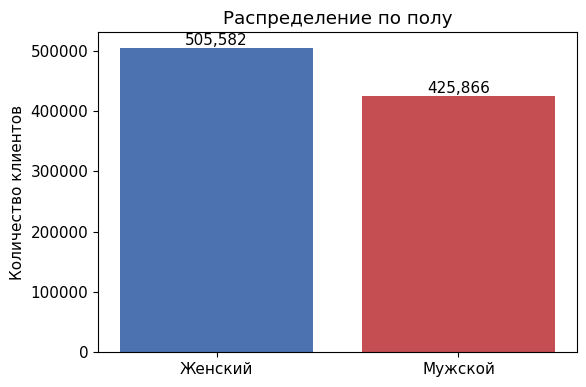

In [20]:
# Пол
fig, ax = plt.subplots(figsize=(6, 4))
sex_counts = snap['sexo'].value_counts()
sex_labels = {'H': 'Мужской', 'V': 'Женский'}
ax.bar([sex_labels.get(x, x) for x in sex_counts.index], sex_counts.values,
       color=['#4C72B0', '#C44E52'])
ax.set_ylabel('Количество клиентов')
ax.set_title('Распределение по полу')
for i, v in enumerate(sex_counts.values):
    ax.text(i, v + 5000, f'{v:,}', ha='center')
plt.tight_layout()
plt.show()

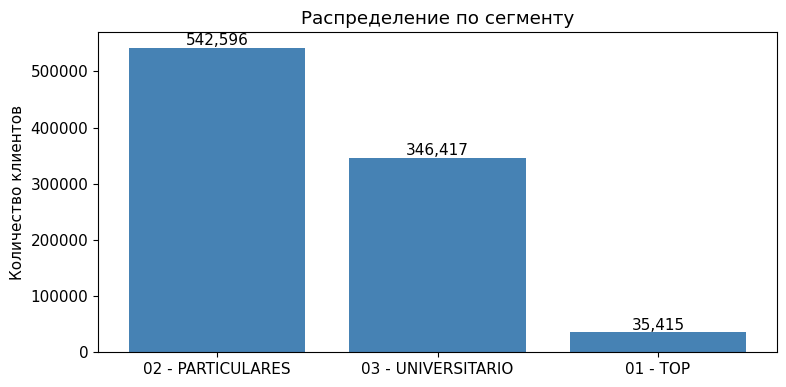

In [21]:
# Сегмент
fig, ax = plt.subplots(figsize=(8, 4))
seg_counts = snap['segmento'].value_counts()
ax.bar(seg_counts.index.astype(str), seg_counts.values, color='steelblue')
ax.set_ylabel('Количество клиентов')
ax.set_title('Распределение по сегменту')
for i, v in enumerate(seg_counts.values):
    ax.text(i, v + 5000, f'{v:,}', ha='center')
plt.tight_layout()
plt.show()

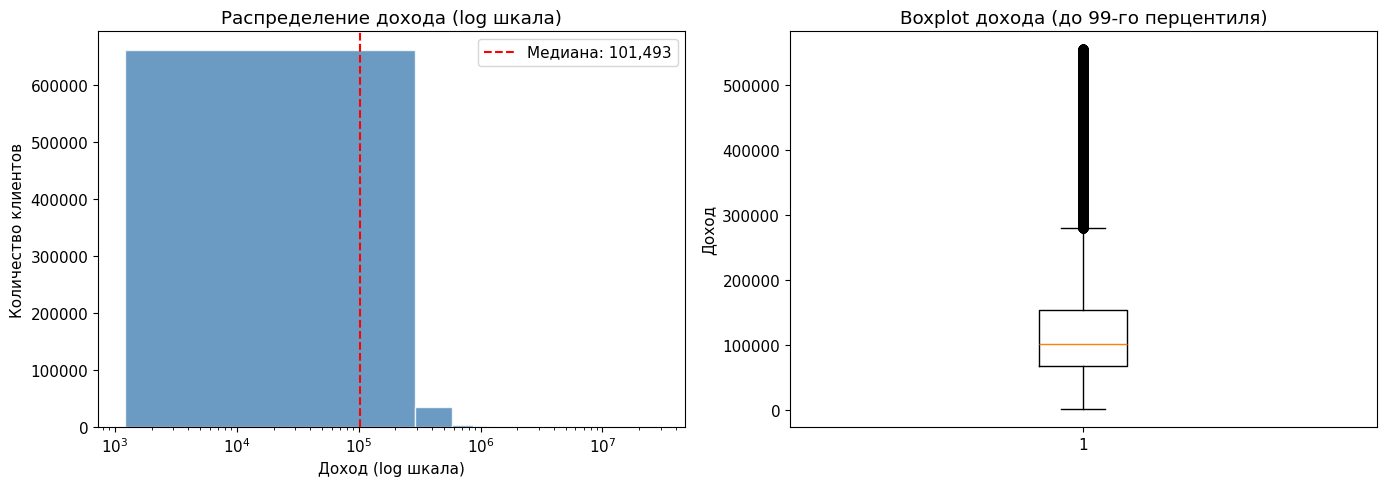

Доход: медиана=101,493, среднее=134,090, макс=28,894,396


In [22]:
# Доход (renta): гистограмма в log-шкале + boxplot
renta_valid = snap['renta'].dropna()
renta_99 = renta_valid[renta_valid <= renta_valid.quantile(0.99)]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(renta_valid[renta_valid > 0], bins=100, color='steelblue',
             edgecolor='white', alpha=0.8)
axes[0].set_xscale('log')
axes[0].set_xlabel('Доход (log шкала)')
axes[0].set_ylabel('Количество клиентов')
axes[0].set_title('Распределение дохода (log шкала)')
axes[0].axvline(renta_valid.median(), color='red', linestyle='--',
                label=f'Медиана: {renta_valid.median():,.0f}')
axes[0].legend()

axes[1].boxplot(renta_99, vert=True)
axes[1].set_ylabel('Доход')
axes[1].set_title('Boxplot дохода (до 99-го перцентиля)')

plt.tight_layout()
plt.show()

print(f'Доход: медиана={renta_valid.median():,.0f}, '
      f'среднее={renta_valid.mean():,.0f}, '
      f'макс={renta_valid.max():,.0f}')

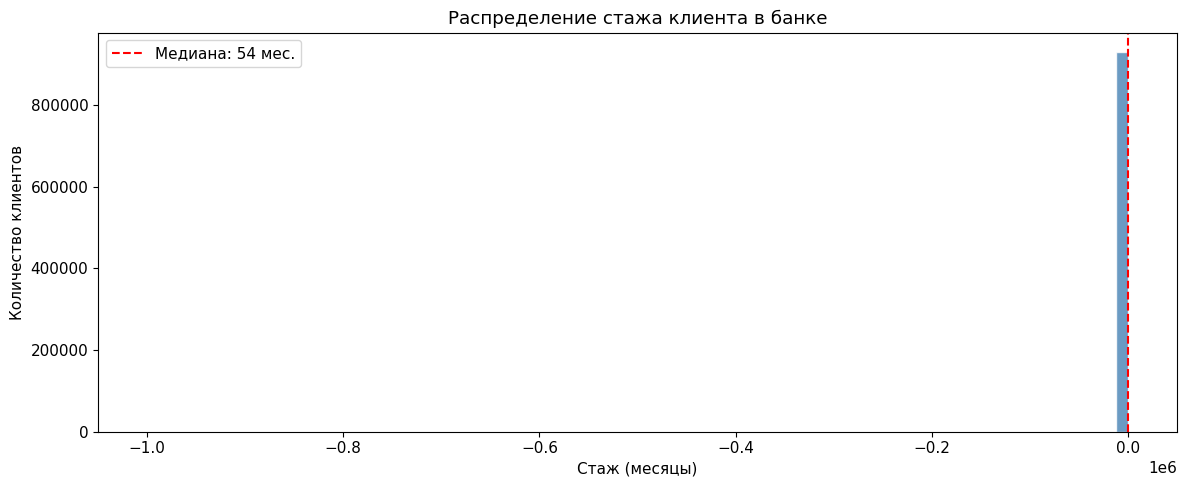

In [23]:
# Стаж клиента (antiguedad)
fig, ax = plt.subplots(figsize=(12, 5))
ant_valid = snap['antiguedad'].dropna()
ax.hist(ant_valid, bins=80, color='steelblue', edgecolor='white', alpha=0.8)
ax.set_xlabel('Стаж (месяцы)')
ax.set_ylabel('Количество клиентов')
ax.set_title('Распределение стажа клиента в банке')
ax.axvline(ant_valid.median(), color='red', linestyle='--',
           label=f'Медиана: {ant_valid.median():.0f} мес.')
ax.legend()
plt.tight_layout()
plt.show()

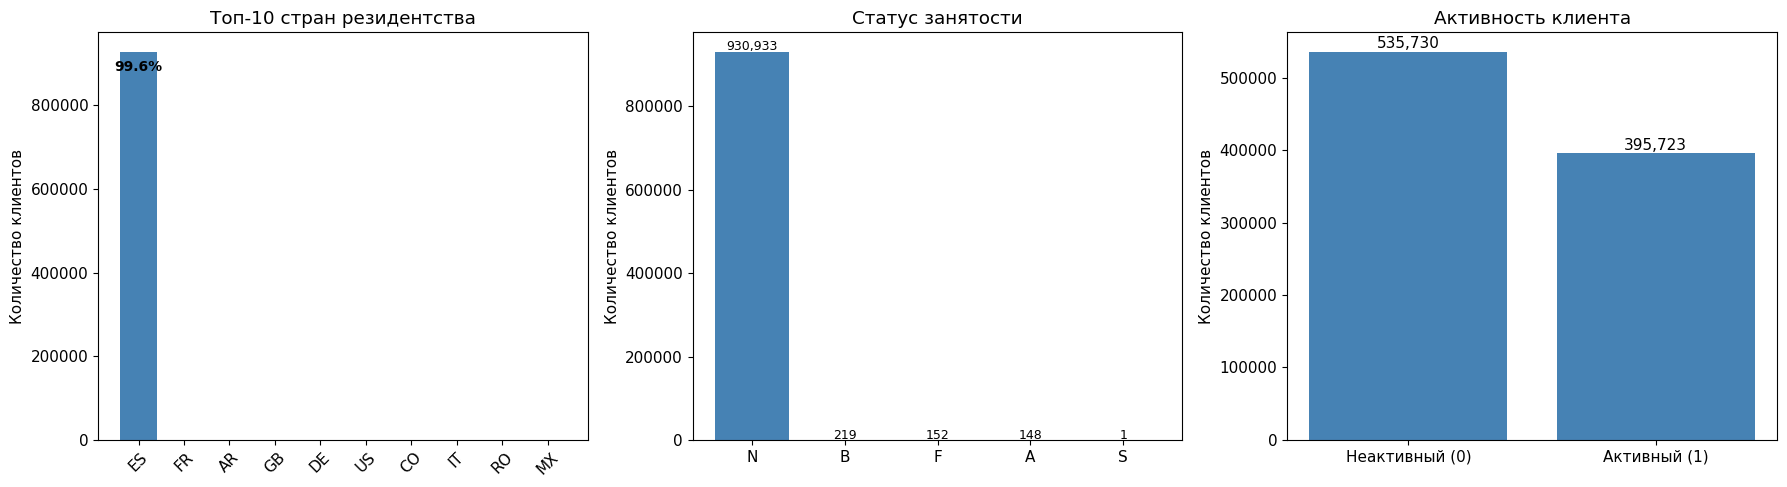

In [24]:
# Страна резидентства
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Страна
country_counts = snap['pais_residencia'].value_counts()
top_countries = country_counts.head(10)
axes[0].bar(top_countries.index.astype(str), top_countries.values, color='steelblue')
axes[0].set_ylabel('Количество клиентов')
axes[0].set_title('Топ-10 стран резидентства')
axes[0].tick_params(axis='x', rotation=45)
pct_es = country_counts.iloc[0] / country_counts.sum() * 100
axes[0].text(0, country_counts.iloc[0] * 0.95, f'{pct_es:.1f}%', ha='center',
             fontsize=10, fontweight='bold')

# Статус занятости
emp_counts = snap['ind_empleado'].value_counts()
axes[1].bar(emp_counts.index.astype(str), emp_counts.values, color='steelblue')
axes[1].set_ylabel('Количество клиентов')
axes[1].set_title('Статус занятости')
for i, v in enumerate(emp_counts.values):
    axes[1].text(i, v + 3000, f'{v:,}', ha='center', fontsize=9)

# Активность клиента
act_counts = snap['ind_actividad_cliente'].value_counts().sort_index()
axes[2].bar(['Неактивный (0)', 'Активный (1)'], act_counts.values, color='steelblue')
axes[2].set_ylabel('Количество клиентов')
axes[2].set_title('Активность клиента')
for i, v in enumerate(act_counts.values):
    axes[2].text(i, v + 5000, f'{v:,}', ha='center')

plt.tight_layout()
plt.show()

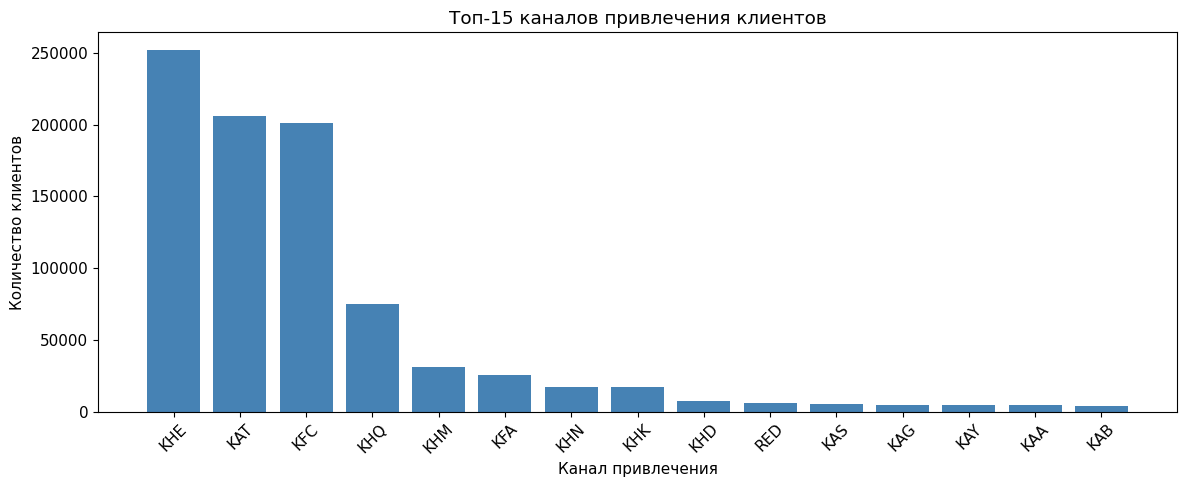

In [25]:
# Каналы привлечения: top-15
fig, ax = plt.subplots(figsize=(12, 5))
canal_counts = snap['canal_entrada'].value_counts().head(15)
ax.bar(canal_counts.index.astype(str), canal_counts.values, color='steelblue')
ax.set_xlabel('Канал привлечения')
ax.set_ylabel('Количество клиентов')
ax.set_title('Топ-15 каналов привлечения клиентов')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

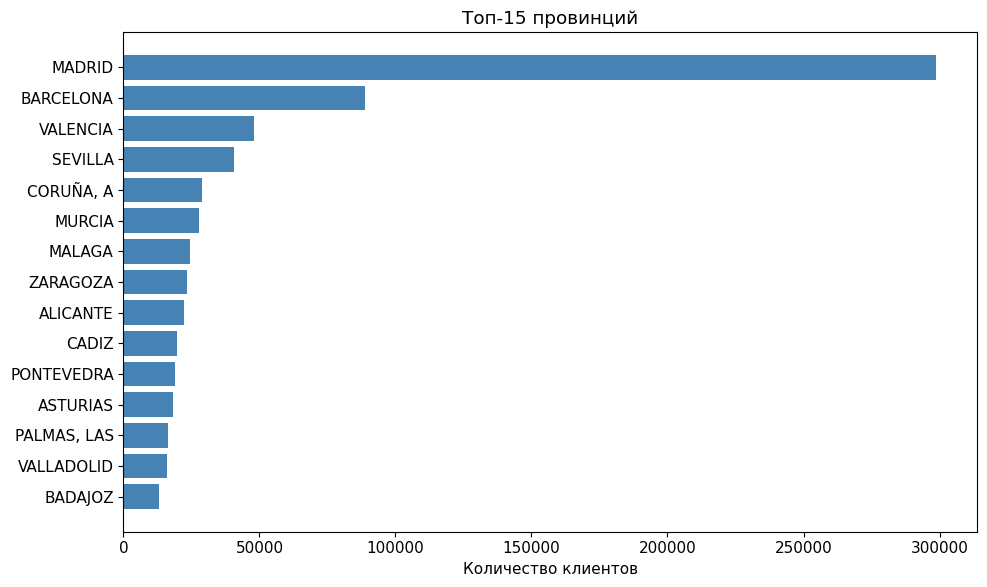

In [26]:
# Провинции: top-15
fig, ax = plt.subplots(figsize=(10, 6))
prov_counts = snap['nomprov'].value_counts().head(15)
ax.barh(prov_counts.index[::-1].astype(str), prov_counts.values[::-1], color='steelblue')
ax.set_xlabel('Количество клиентов')
ax.set_title('Топ-15 провинций')
plt.tight_layout()
plt.show()

## 6. Анализ продуктов

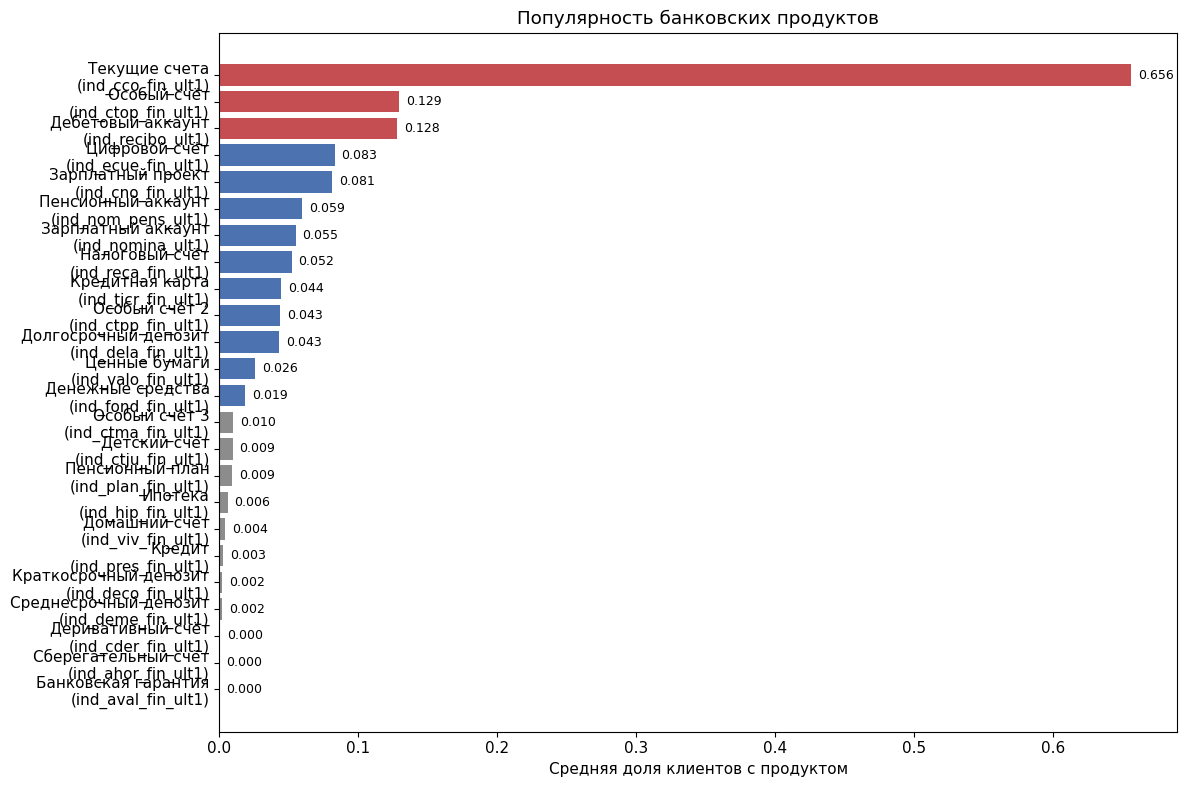

In [27]:
# Популярность продуктов (средняя доля клиентов за весь период)
product_means = df[PRODUCT_COLS].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))
colors = ['#C44E52' if v > 0.1 else '#4C72B0' if v > 0.01 else '#8C8C8C'
          for v in product_means.values]
y_labels = [f'{PRODUCT_NAMES.get(c, c)}\n({c})' for c in product_means.index]
ax.barh(y_labels[::-1], product_means.values[::-1], color=colors[::-1])
ax.set_xlabel('Средняя доля клиентов с продуктом')
ax.set_title('Популярность банковских продуктов')
for i, v in enumerate(product_means.values[::-1]):
    ax.text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=9)
plt.tight_layout()
plt.show()

In [28]:
# Таблица популярности
popularity = pd.DataFrame({
    'Продукт': [PRODUCT_NAMES[c] for c in product_means.index],
    'Колонка': product_means.index,
    'Средняя доля': product_means.values,
    '% клиентов': (product_means.values * 100).round(2)
})
popularity

,Продукт,Колонка,Средняя доля,% клиентов
0,Текущие счета,ind_cco_fin_ult1,0.656272,65.63
1,Особый счёт,ind_ctop_fin_ult1,0.129180,12.92
2,Дебетовый аккаунт,ind_recibo_ult1,0.128110,12.81
3,Цифровой счёт,ind_ecue_fin_ult1,0.082824,8.28
4,Зарплатный проект,ind_cno_fin_ult1,0.080988,8.10
5,Пенсионный аккаунт,ind_nom_pens_ult1,0.059463,5.95
6,Зарплатный аккаунт,ind_nomina_ult1,0.054756,5.48
7,Налоговый счёт,ind_reca_fin_ult1,0.051896,5.19
8,Кредитная карта,ind_tjcr_fin_ult1,0.044463,4.45
9,Особый счёт 2,ind_ctpp_fin_ult1,0.043368,4.34


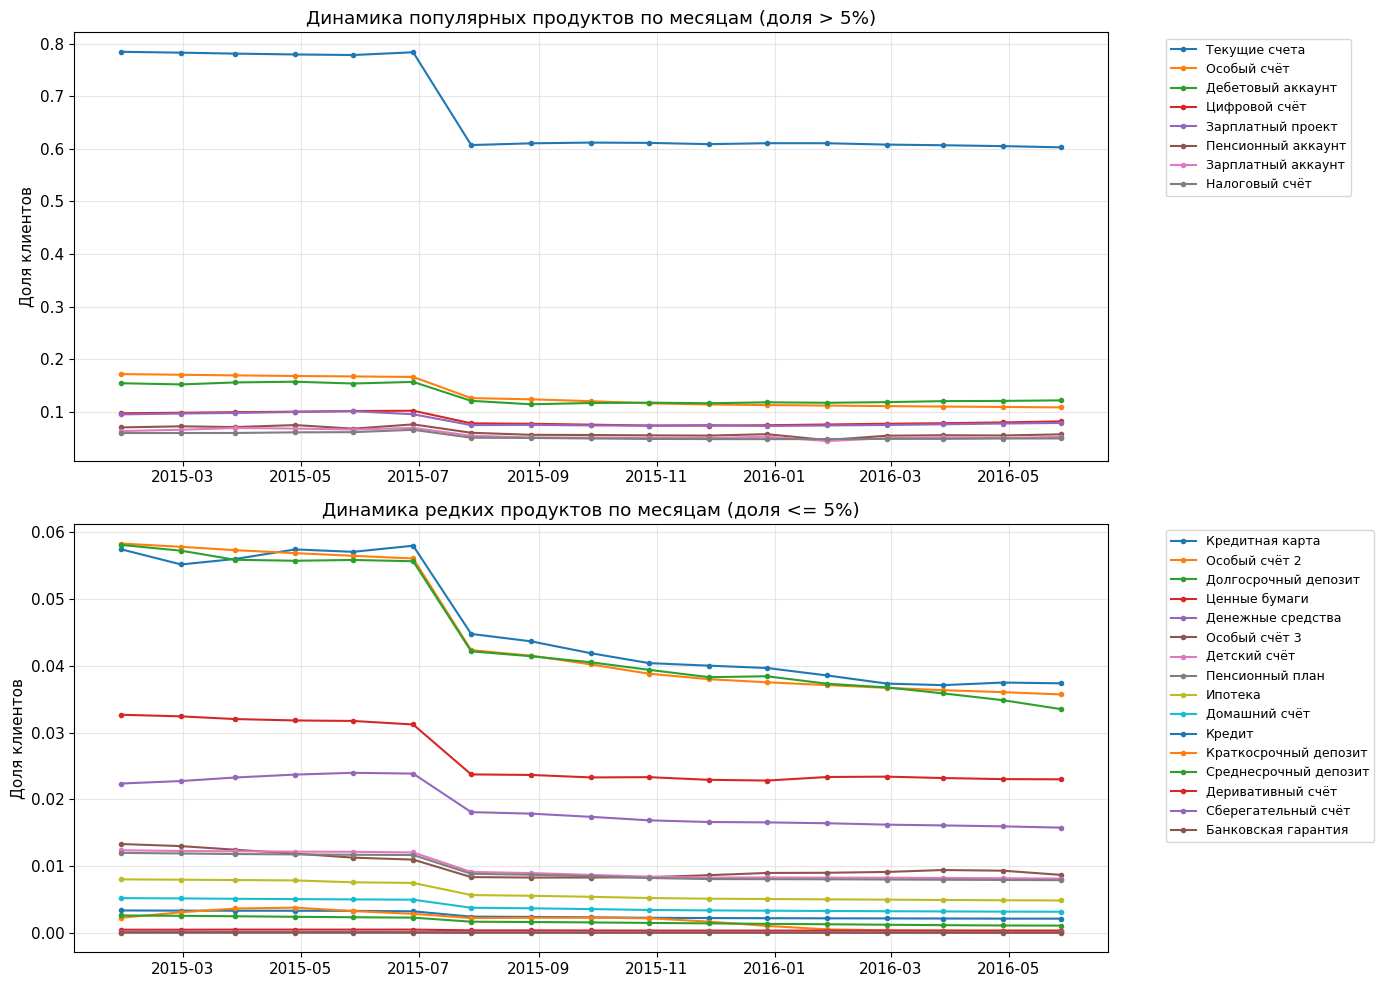

In [29]:
# Динамика продуктов по месяцам
monthly_products = df.groupby('fecha_dato')[PRODUCT_COLS].mean()

# Популярные продукты (> 5% в среднем)
popular = product_means[product_means > 0.05].index.tolist()
rare = product_means[(product_means > 0) & (product_means <= 0.05)].index.tolist()

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

for col in popular:
    axes[0].plot(monthly_products.index, monthly_products[col],
                 marker='o', markersize=3, label=PRODUCT_NAMES[col])
axes[0].set_ylabel('Доля клиентов')
axes[0].set_title('Динамика популярных продуктов по месяцам (доля > 5%)')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0].grid(True, alpha=0.3)

for col in rare:
    axes[1].plot(monthly_products.index, monthly_products[col],
                 marker='o', markersize=3, label=PRODUCT_NAMES[col])
axes[1].set_ylabel('Доля клиентов')
axes[1].set_title('Динамика редких продуктов по месяцам (доля <= 5%)')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Анализ переходов 0 → 1 (новые подключения продуктов)

Ключевой блок: вычисляем, какие продукты клиенты **подключили** (перешли из 0 в 1) в каждом месяце. Это целевая переменная для задачи моделирования.

In [30]:
# Вычисление переходов 0 → 1
# Сортируем по клиенту и дате, затем shift для получения предыдущего месяца
df = df.sort_values(['ncodpers', 'fecha_dato']).reset_index(drop=True)

# Предыдущие значения продуктов (shift внутри группы клиента)
prev = df.groupby('ncodpers')[PRODUCT_COLS].shift(1)

# Переходы: текущее значение = 1, предыдущее = 0
transitions = ((df[PRODUCT_COLS].values == 1) & (prev.values == 0)).astype(np.int8)
transitions_df = pd.DataFrame(transitions, columns=[f'{c}_new' for c in PRODUCT_COLS],
                               index=df.index)

# Добавляем метаданные
transitions_df['fecha_dato'] = df['fecha_dato'].values
transitions_df['ncodpers'] = df['ncodpers'].values

# Убираем первый месяц каждого клиента (нет предыдущего)
transitions_df = transitions_df[prev.notna().any(axis=1)]

print(f'Записей с переходами: {len(transitions_df):,}')
print(f'Всего переходов 0→1: {transitions_df[[f"{c}_new" for c in PRODUCT_COLS]].sum().sum():,}')

Записей с переходами: 12,669,961


Всего переходов 0→1: 562,574


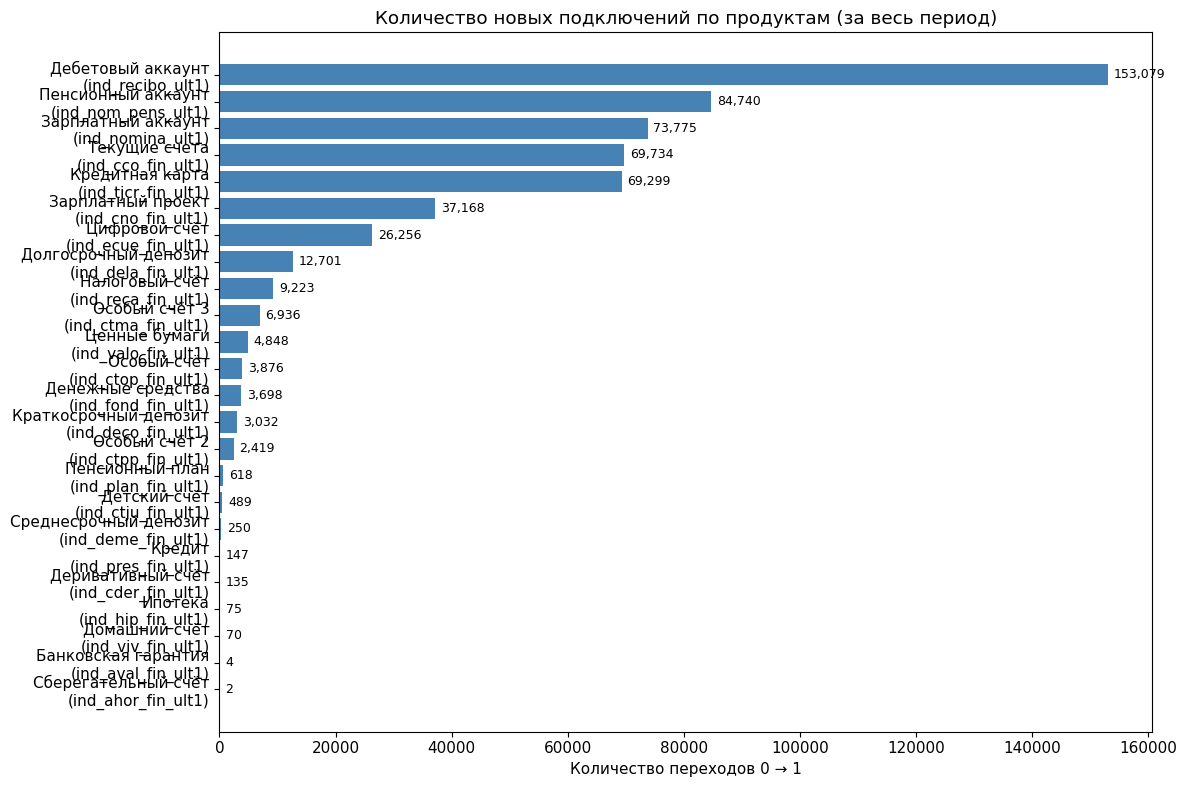

In [31]:
# Количество переходов по продуктам
new_cols = [f'{c}_new' for c in PRODUCT_COLS]
transition_counts = transitions_df[new_cols].sum().sort_values(ascending=False)
transition_counts.index = [c.replace('_new', '') for c in transition_counts.index]

fig, ax = plt.subplots(figsize=(12, 8))
y_labels = [f'{PRODUCT_NAMES.get(c, c)}\n({c})' for c in transition_counts.index]
ax.barh(y_labels[::-1], transition_counts.values[::-1], color='steelblue')
ax.set_xlabel('Количество переходов 0 → 1')
ax.set_title('Количество новых подключений по продуктам (за весь период)')
for i, v in enumerate(transition_counts.values[::-1]):
    ax.text(v + 1000, i, f'{v:,}', va='center', fontsize=9)
plt.tight_layout()
plt.show()

In [32]:
# Таблица переходов
trans_table = pd.DataFrame({
    'Продукт': [PRODUCT_NAMES[c] for c in transition_counts.index],
    'Колонка': transition_counts.index,
    'Кол-во подключений': transition_counts.values,
    'Доля от всех переходов (%)': (transition_counts.values / transition_counts.sum() * 100).round(2)
})
trans_table

,Продукт,Колонка,Кол-во подключений,Доля от всех переходов (%)
0,Дебетовый аккаунт,ind_recibo_ult1,153079,27.21
1,Пенсионный аккаунт,ind_nom_pens_ult1,84740,15.06
2,Зарплатный аккаунт,ind_nomina_ult1,73775,13.11
3,Текущие счета,ind_cco_fin_ult1,69734,12.40
4,Кредитная карта,ind_tjcr_fin_ult1,69299,12.32
5,Зарплатный проект,ind_cno_fin_ult1,37168,6.61
6,Цифровой счёт,ind_ecue_fin_ult1,26256,4.67
7,Долгосрочный депозит,ind_dela_fin_ult1,12701,2.26
8,Налоговый счёт,ind_reca_fin_ult1,9223,1.64
9,Особый счёт 3,ind_ctma_fin_ult1,6936,1.23


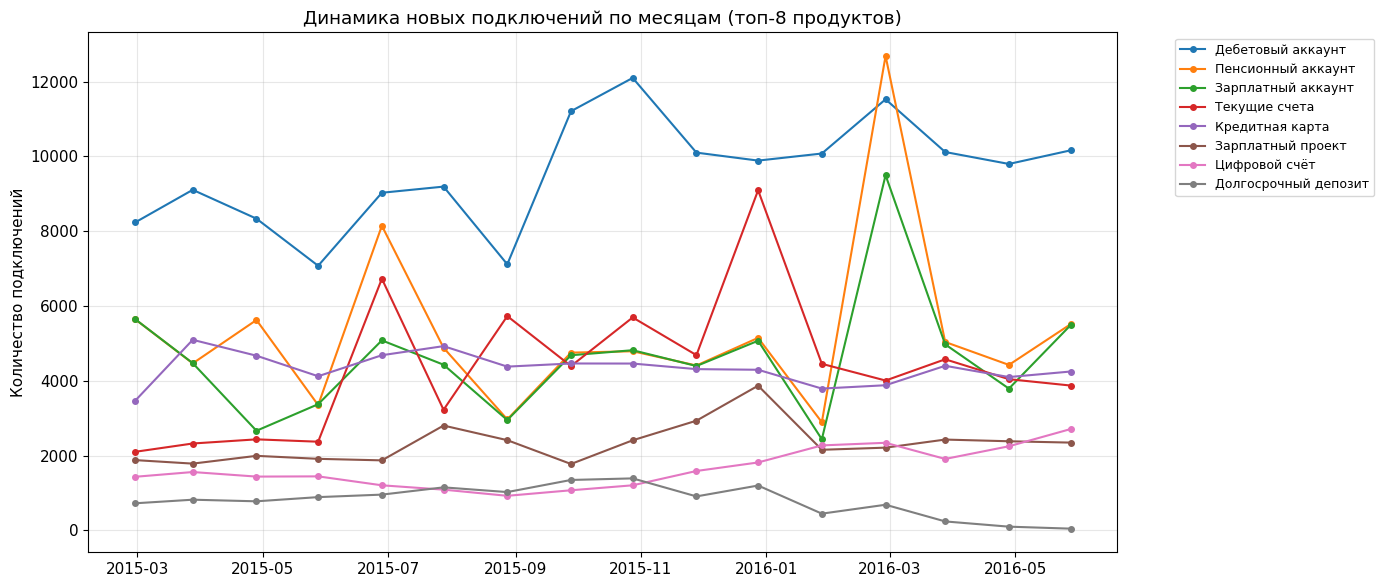

In [33]:
# Динамика переходов по месяцам (top-8 продуктов)
top8_products = transition_counts.head(8).index.tolist()
monthly_transitions = transitions_df.groupby('fecha_dato')[
    [f'{c}_new' for c in top8_products]
].sum()

fig, ax = plt.subplots(figsize=(14, 6))
for col in top8_products:
    ax.plot(monthly_transitions.index, monthly_transitions[f'{col}_new'],
            marker='o', markersize=4, label=PRODUCT_NAMES[col])
ax.set_ylabel('Количество подключений')
ax.set_title('Динамика новых подключений по месяцам (топ-8 продуктов)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [34]:
# Среднее количество новых продуктов на клиента в месяц
transitions_df['n_new'] = transitions_df[new_cols].sum(axis=1)

avg_new = transitions_df.groupby('fecha_dato')['n_new'].mean()
print('Среднее кол-во новых продуктов на клиента по месяцам:')
for date, val in avg_new.items():
    print(f'  {date.strftime("%Y-%m")}: {val:.4f}')

print(f'\nОбщее среднее: {transitions_df["n_new"].mean():.4f}')
print(f'Клиентов хотя бы с 1 новым продуктом: '
      f'{(transitions_df["n_new"] > 0).sum():,} '
      f'({(transitions_df["n_new"] > 0).mean()*100:.2f}%)')

Среднее кол-во новых продуктов на клиента по месяцам:
  2015-02: 0.0505
  2015-03: 0.0514
  2015-04: 0.0490
  2015-05: 0.0424
  2015-06: 0.0670
  2015-07: 0.0529
  2015-08: 0.0356
  2015-09: 0.0424
  2015-10: 0.0461
  2015-11: 0.0396
  2015-12: 0.0469
  2016-01: 0.0341
  2016-02: 0.0536
  2016-03: 0.0383
  2016-04: 0.0357
  2016-05: 0.0387

Общее среднее: 0.0444
Клиентов хотя бы с 1 новым продуктом: 447,231 (3.53%)


## 7. Корреляции между продуктами

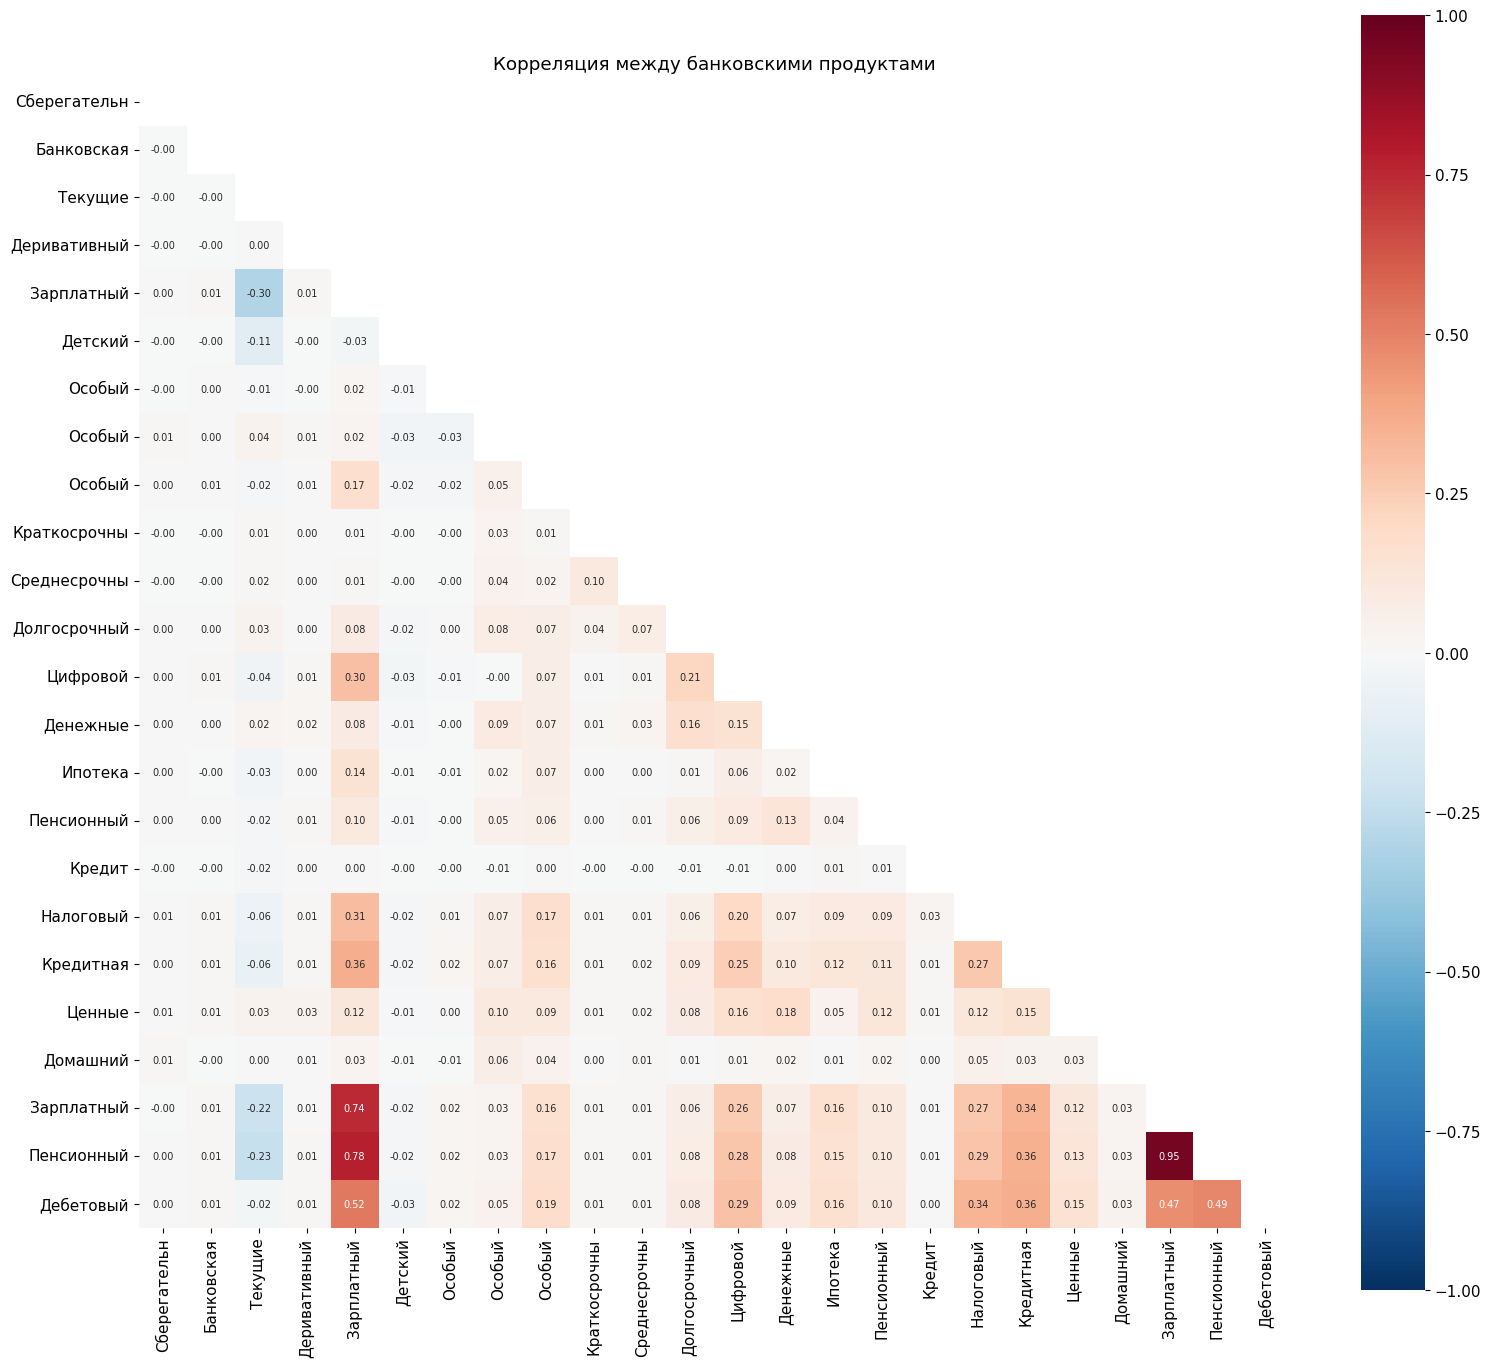

In [35]:
# Корреляционная матрица продуктов
product_corr = snap[PRODUCT_COLS].corr()

# Треугольная heatmap
mask = np.triu(np.ones_like(product_corr, dtype=bool))
short_names = [PRODUCT_NAMES[c].split()[0][:12] for c in PRODUCT_COLS]

fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(product_corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, square=True,
            xticklabels=short_names, yticklabels=short_names,
            annot_kws={'size': 7}, ax=ax)
ax.set_title('Корреляция между банковскими продуктами')
plt.tight_layout()
plt.show()

In [36]:
# Топ-10 наиболее коррелированных пар
corr_pairs = []
for i in range(len(PRODUCT_COLS)):
    for j in range(i + 1, len(PRODUCT_COLS)):
        corr_pairs.append({
            'Продукт 1': PRODUCT_NAMES[PRODUCT_COLS[i]],
            'Продукт 2': PRODUCT_NAMES[PRODUCT_COLS[j]],
            'Корреляция': product_corr.iloc[i, j]
        })

corr_pairs_df = pd.DataFrame(corr_pairs)
corr_pairs_df['|Корреляция|'] = corr_pairs_df['Корреляция'].abs()
top_corr = corr_pairs_df.nlargest(10, '|Корреляция|')[['Продукт 1', 'Продукт 2', 'Корреляция']]
top_corr

,Продукт 1,Продукт 2,Корреляция
273,Зарплатный аккаунт,Пенсионный аккаунт,0.953632
103,Зарплатный проект,Пенсионный аккаунт,0.777617
102,Зарплатный проект,Зарплатный аккаунт,0.744916
104,Зарплатный проект,Дебетовый аккаунт,0.524529
275,Пенсионный аккаунт,Дебетовый аккаунт,0.487883
274,Зарплатный аккаунт,Дебетовый аккаунт,0.467018
265,Кредитная карта,Дебетовый аккаунт,0.362598
99,Зарплатный проект,Кредитная карта,0.361728
264,Кредитная карта,Пенсионный аккаунт,0.358298
260,Налоговый счёт,Дебетовый аккаунт,0.342994


In [37]:
# Условные вероятности для связанных пар
# P(B=1 | A=1) для топ-коррелированных пар
print('Условные вероятности P(B=1 | A=1) для связанных продуктов:\n')

cond_pairs = [
    ('ind_nomina_ult1', 'ind_nom_pens_ult1'),
    ('ind_cno_fin_ult1', 'ind_nomina_ult1'),
    ('ind_cno_fin_ult1', 'ind_recibo_ult1'),
    ('ind_recibo_ult1', 'ind_nom_pens_ult1'),
    ('ind_ecue_fin_ult1', 'ind_cco_fin_ult1'),
]

for a, b in cond_pairs:
    has_a = snap[a] == 1
    if has_a.sum() > 0:
        p_b_given_a = snap.loc[has_a, b].mean()
        p_b = snap[b].mean()
        print(f'  P({PRODUCT_NAMES[b][:20]} | {PRODUCT_NAMES[a][:20]}) = {p_b_given_a:.3f}'
              f'  (безусловная: {p_b:.3f})')

Условные вероятности P(B=1 | A=1) для связанных продуктов:

  P(Пенсионный аккаунт | Зарплатный аккаунт) = 1.000  (безусловная: 0.057)
  P(Зарплатный аккаунт | Зарплатный проект) = 0.618  (безусловная: 0.052)
  P(Дебетовый аккаунт | Зарплатный проект) = 0.708  (безусловная: 0.121)
  P(Пенсионный аккаунт | Дебетовый аккаунт) = 0.360  (безусловная: 0.057)
  P(Текущие счета | Цифровой счёт) = 0.538  (безусловная: 0.603)


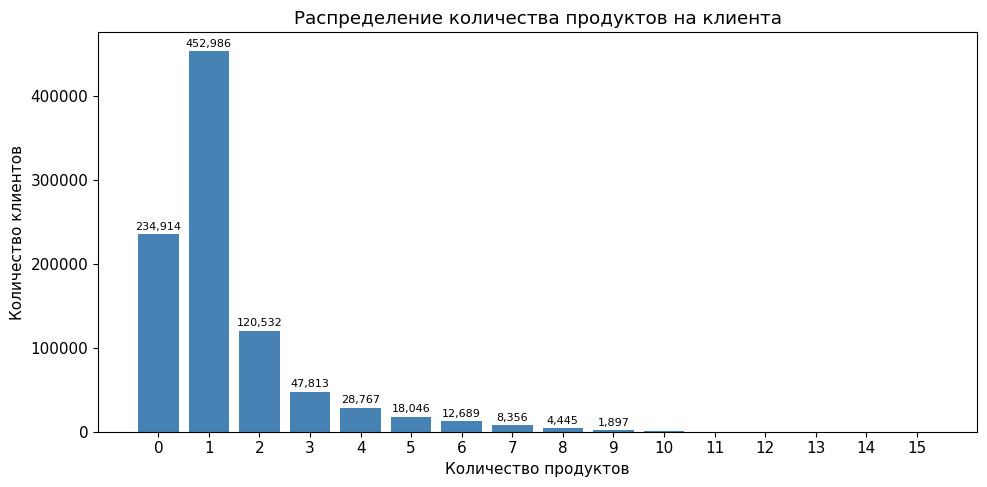

Среднее кол-во продуктов: 1.33
Медиана: 1
Макс: 15
Клиентов без продуктов: 234,914


In [38]:
# Распределение количества продуктов на клиента
n_products = snap[PRODUCT_COLS].sum(axis=1)

fig, ax = plt.subplots(figsize=(10, 5))
counts = n_products.value_counts().sort_index()
ax.bar(counts.index, counts.values, color='steelblue')
ax.set_xlabel('Количество продуктов')
ax.set_ylabel('Количество клиентов')
ax.set_title('Распределение количества продуктов на клиента')
ax.set_xticks(range(0, int(counts.index.max()) + 1))
for i, (idx, v) in enumerate(counts.items()):
    if v > 1000:
        ax.text(idx, v + 5000, f'{v:,}', ha='center', fontsize=8)
plt.tight_layout()
plt.show()

print(f'Среднее кол-во продуктов: {n_products.mean():.2f}')
print(f'Медиана: {n_products.median():.0f}')
print(f'Макс: {n_products.max():.0f}')
print(f'Клиентов без продуктов: {(n_products == 0).sum():,}')

## 8. Клиентские сегменты vs продукты

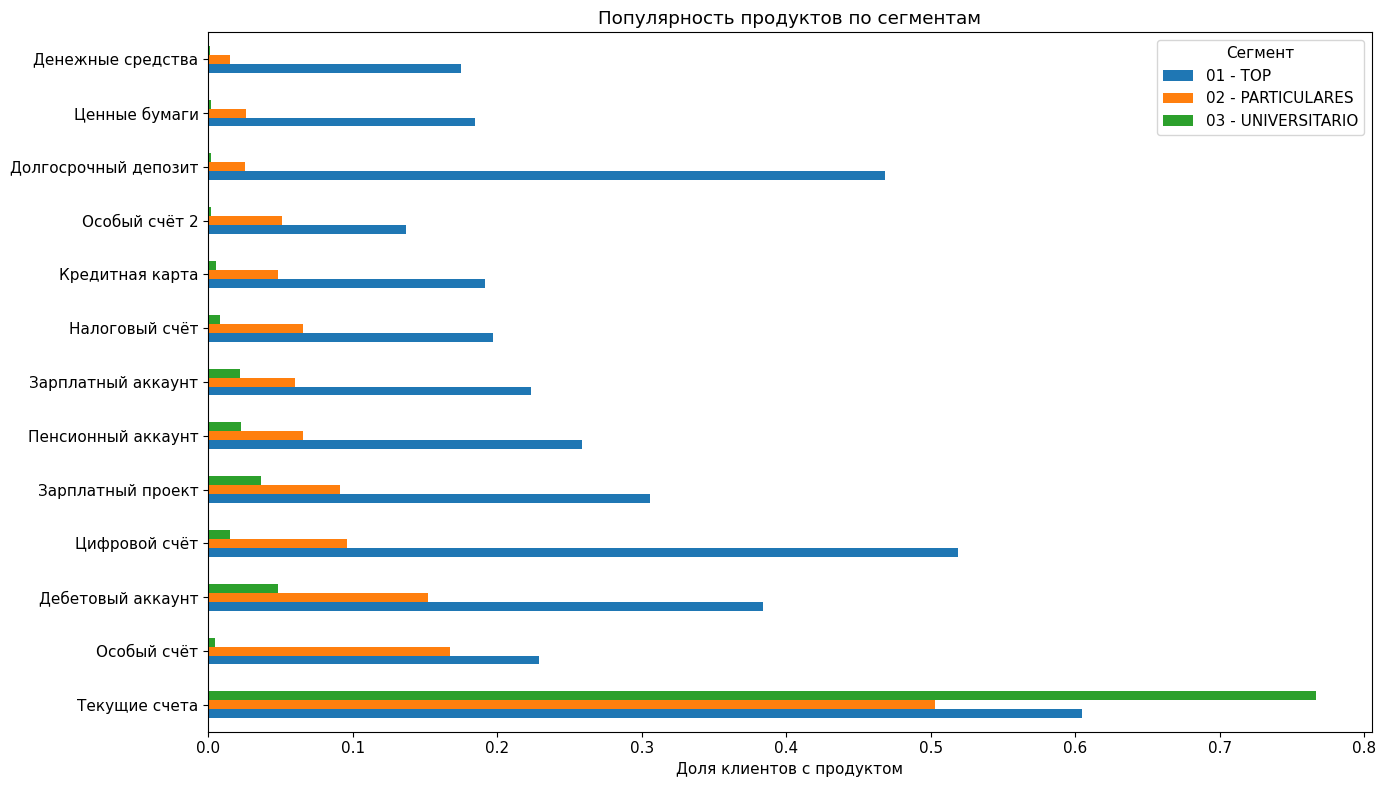

In [39]:
# Продукты по сегменту
seg_products = snap.groupby('segmento')[PRODUCT_COLS].mean()

# Отбираем продукты с заметной разницей
top_products = product_means[product_means > 0.01].index.tolist()

seg_plot = seg_products[top_products].T
seg_plot.index = [PRODUCT_NAMES[c][:20] for c in seg_plot.index]

fig, ax = plt.subplots(figsize=(14, 8))
seg_plot.plot(kind='barh', ax=ax)
ax.set_xlabel('Доля клиентов с продуктом')
ax.set_title('Популярность продуктов по сегментам')
ax.legend(title='Сегмент')
plt.tight_layout()
plt.show()

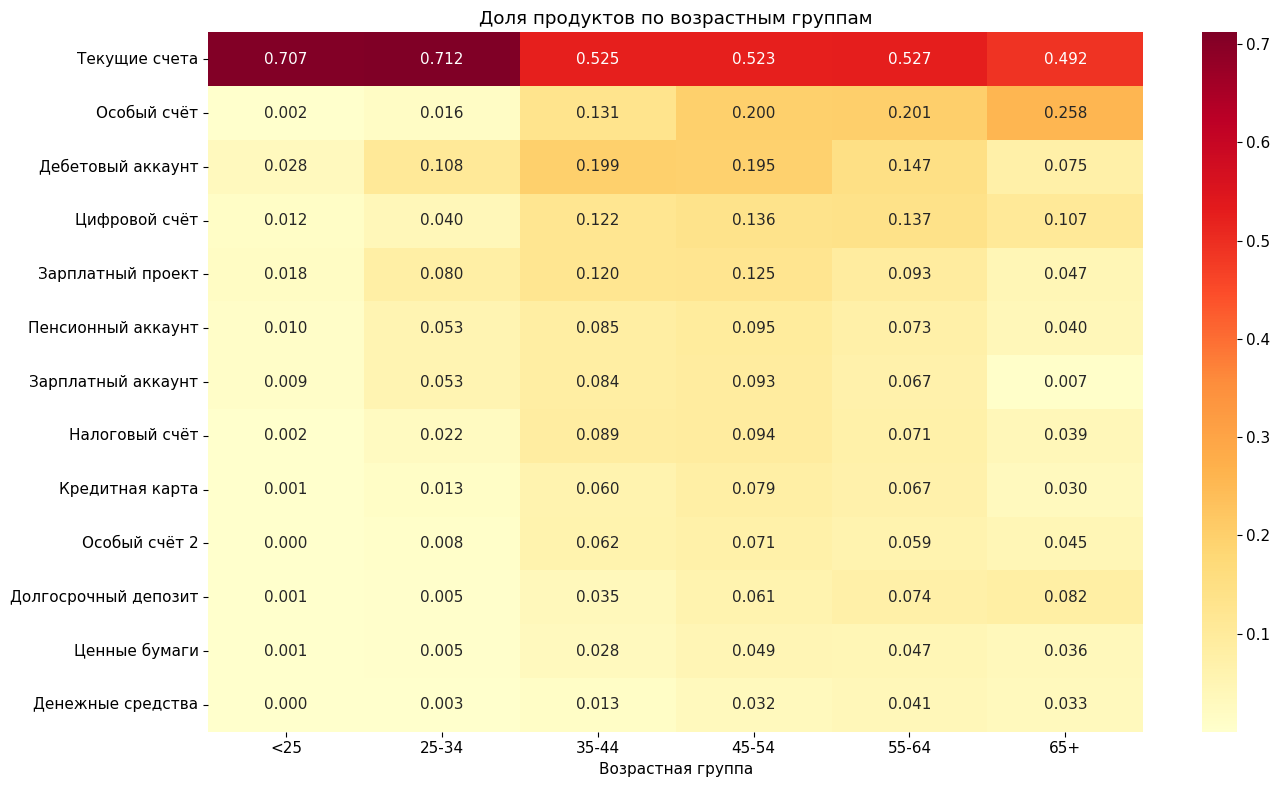

In [40]:
# Продукты по возрастным группам
age_bins = [0, 25, 35, 45, 55, 65, 120]
age_labels = ['<25', '25-34', '35-44', '45-54', '55-64', '65+']
snap['age_group'] = pd.cut(snap['age'], bins=age_bins, labels=age_labels, right=False)

age_products = snap.groupby('age_group', observed=True)[top_products].mean()

fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(age_products.T.rename(index=PRODUCT_NAMES),
            annot=True, fmt='.3f', cmap='YlOrRd', ax=ax)
ax.set_title('Доля продуктов по возрастным группам')
ax.set_xlabel('Возрастная группа')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

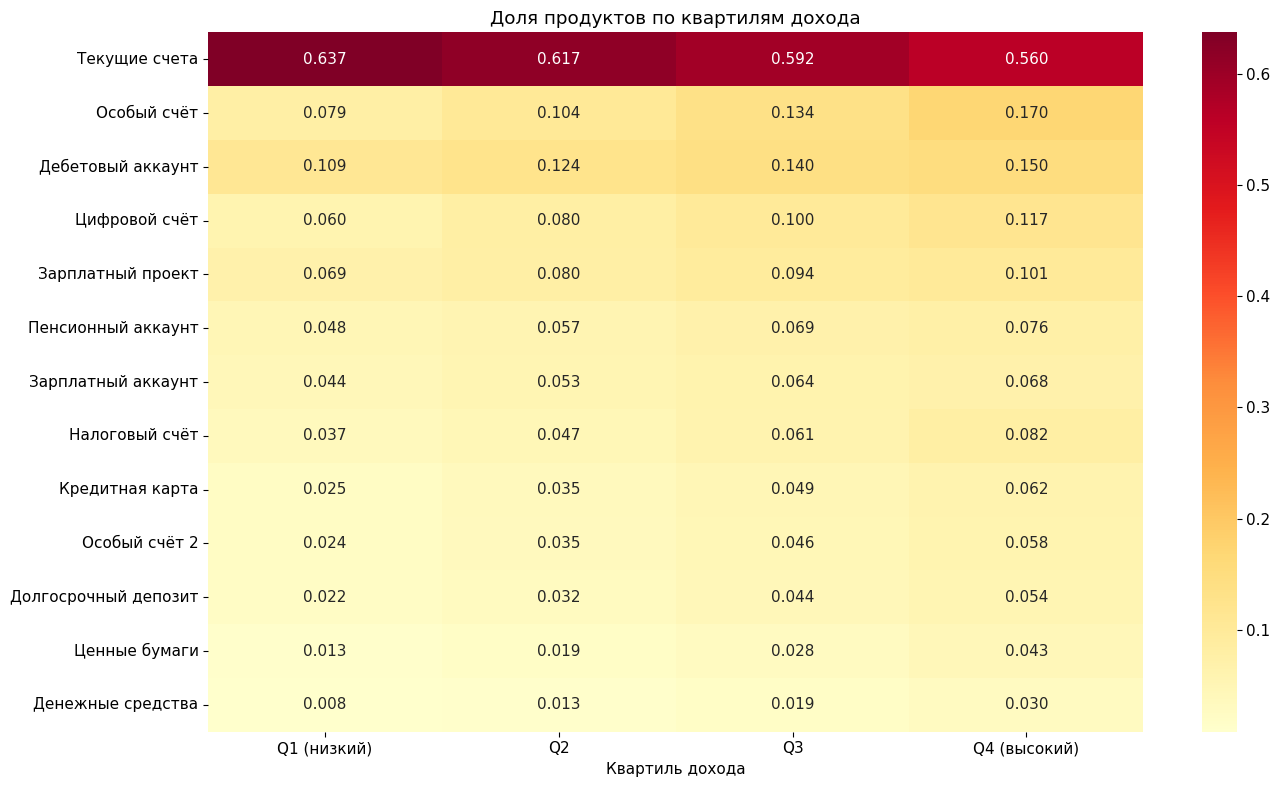

In [41]:
# Продукты по квартилям дохода
renta_notna = snap[snap['renta'].notna()].copy()
renta_notna['renta_q'] = pd.qcut(renta_notna['renta'], q=4,
                                   labels=['Q1 (низкий)', 'Q2', 'Q3', 'Q4 (высокий)'])

renta_products = renta_notna.groupby('renta_q', observed=True)[top_products].mean()

fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(renta_products.T.rename(index=PRODUCT_NAMES),
            annot=True, fmt='.3f', cmap='YlOrRd', ax=ax)
ax.set_title('Доля продуктов по квартилям дохода')
ax.set_xlabel('Квартиль дохода')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

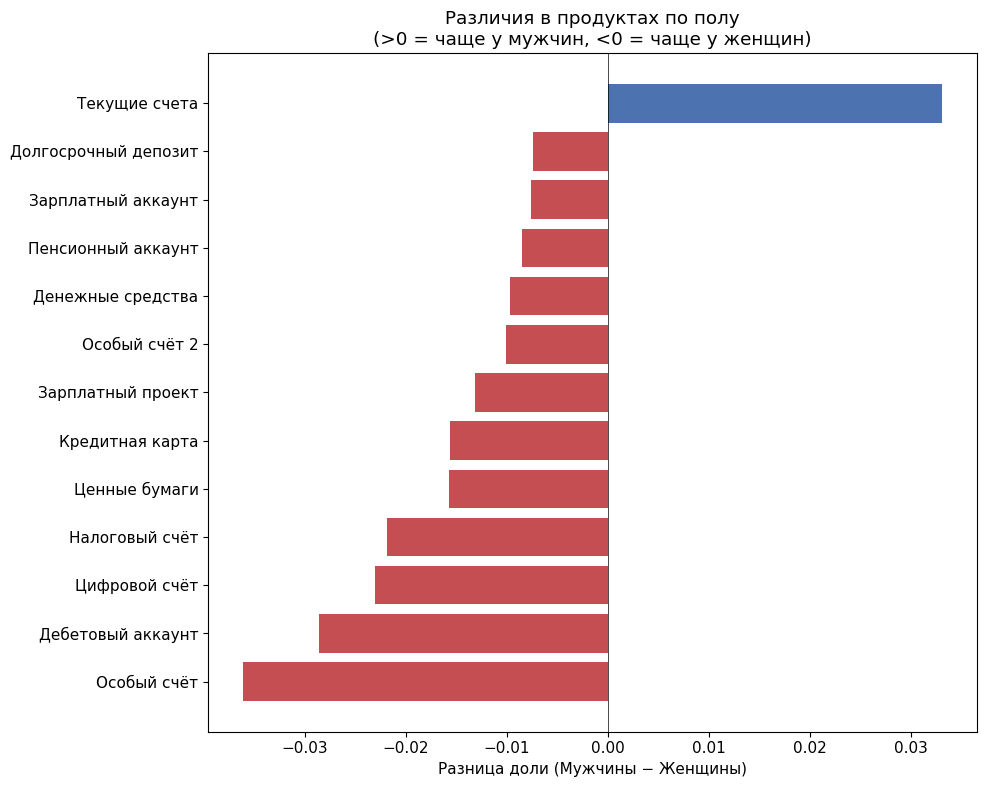

In [42]:
# Продукты по полу (diverging bar chart)
sex_products = snap.groupby('sexo')[top_products].mean()

if 'H' in sex_products.index and 'V' in sex_products.index:
    diff = sex_products.loc['H'] - sex_products.loc['V']
    diff = diff.sort_values()
    
    fig, ax = plt.subplots(figsize=(10, 8))
    colors = ['#C44E52' if v < 0 else '#4C72B0' for v in diff.values]
    y_labels = [PRODUCT_NAMES[c][:25] for c in diff.index]
    ax.barh(y_labels, diff.values, color=colors)
    ax.axvline(0, color='black', linewidth=0.5)
    ax.set_xlabel('Разница доли (Мужчины − Женщины)')
    ax.set_title('Различия в продуктах по полу\n(>0 = чаще у мужчин, <0 = чаще у женщин)')
    plt.tight_layout()
    plt.show()

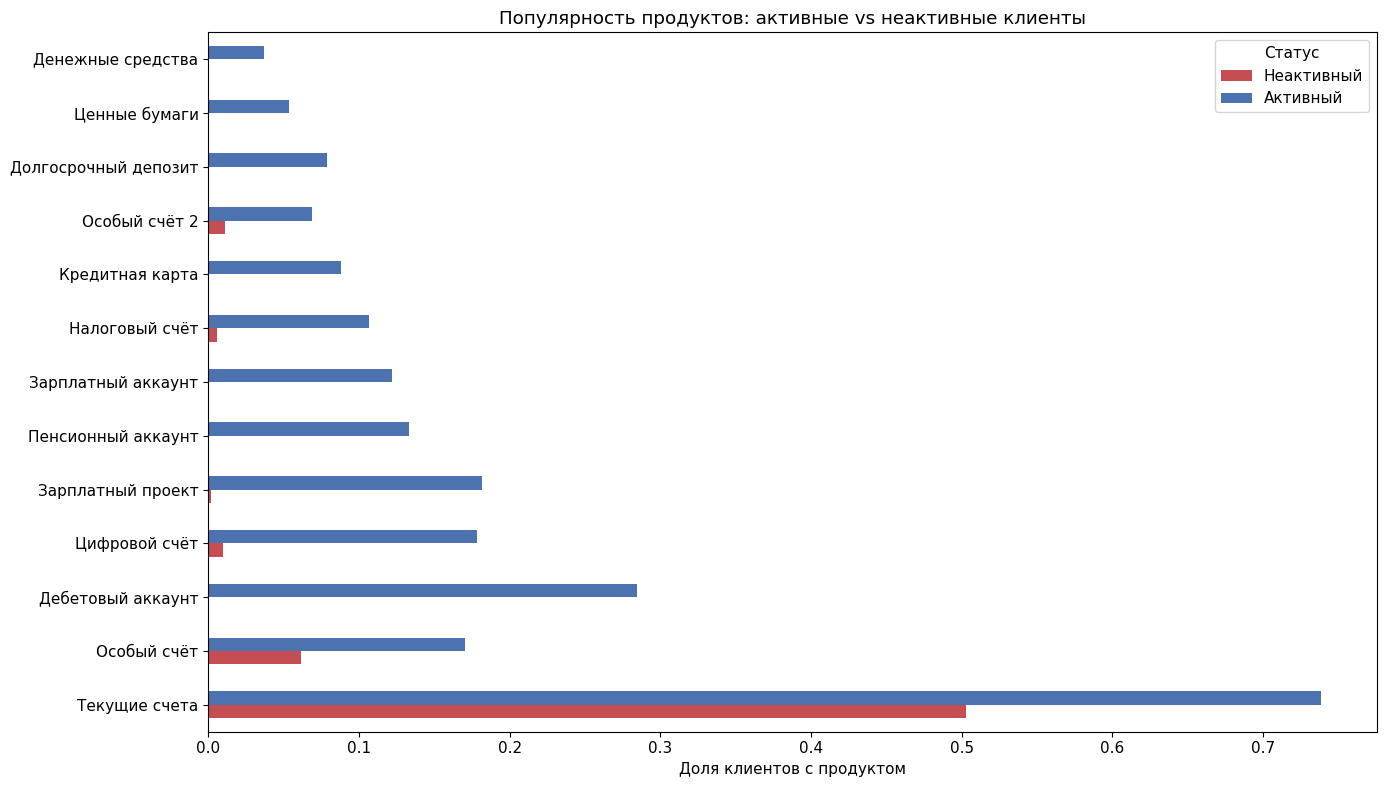

In [43]:
# Продукты: активные vs неактивные клиенты
act_products = snap.groupby('ind_actividad_cliente')[top_products].mean()

act_plot = act_products.T
act_plot.index = [PRODUCT_NAMES[c][:20] for c in act_plot.index]
act_plot.columns = ['Неактивный', 'Активный']

fig, ax = plt.subplots(figsize=(14, 8))
act_plot.plot(kind='barh', ax=ax, color=['#C44E52', '#4C72B0'])
ax.set_xlabel('Доля клиентов с продуктом')
ax.set_title('Популярность продуктов: активные vs неактивные клиенты')
ax.legend(title='Статус')
plt.tight_layout()
plt.show()

## 9. Временной анализ

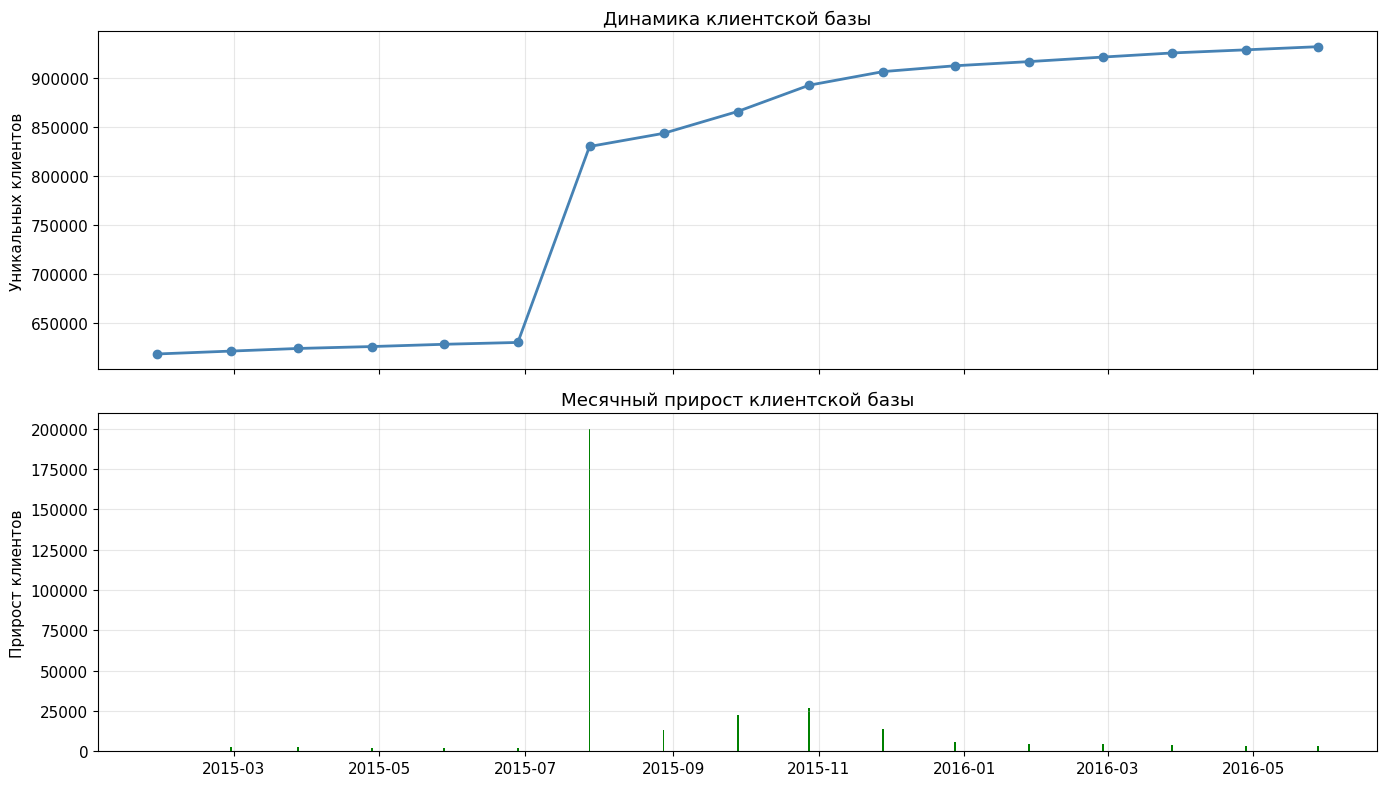

     Месяц  Клиентов  Прирост  Прирост (%)
2015-01-28    618504      NaN          NaN
2015-02-28    621454   2950.0     0.476957
2015-03-28    624118   2664.0     0.428672
2015-04-28    626075   1957.0     0.313562
2015-05-28    628360   2285.0     0.364972
2015-06-28    630249   1889.0     0.300624
2015-07-28    829817 199568.0    31.664945
2015-08-28    843201  13384.0     1.612886
2015-09-28    865440  22239.0     2.637449
2015-10-28    892251  26811.0     3.097962
2015-11-28    906109  13858.0     1.553150
2015-12-28    912021   5912.0     0.652460
2016-01-28    916269   4248.0     0.465779
2016-02-28    920904   4635.0     0.505856
2016-03-28    925076   4172.0     0.453033
2016-04-28    928274   3198.0     0.345701
2016-05-28    931453   3179.0     0.342464


In [44]:
# Рост клиентской базы
monthly_clients = df.groupby('fecha_dato')['ncodpers'].nunique().reset_index()
monthly_clients.columns = ['Месяц', 'Клиентов']
monthly_clients['Прирост'] = monthly_clients['Клиентов'].diff()
monthly_clients['Прирост (%)'] = monthly_clients['Клиентов'].pct_change() * 100

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

axes[0].plot(monthly_clients['Месяц'], monthly_clients['Клиентов'],
             marker='o', color='steelblue', linewidth=2)
axes[0].set_ylabel('Уникальных клиентов')
axes[0].set_title('Динамика клиентской базы')
axes[0].grid(True, alpha=0.3)

colors = ['green' if v > 0 else 'red' for v in monthly_clients['Прирост'].fillna(0)]
axes[1].bar(monthly_clients['Месяц'], monthly_clients['Прирост'].fillna(0), color=colors)
axes[1].set_ylabel('Прирост клиентов')
axes[1].set_title('Месячный прирост клиентской базы')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(monthly_clients.to_string(index=False))

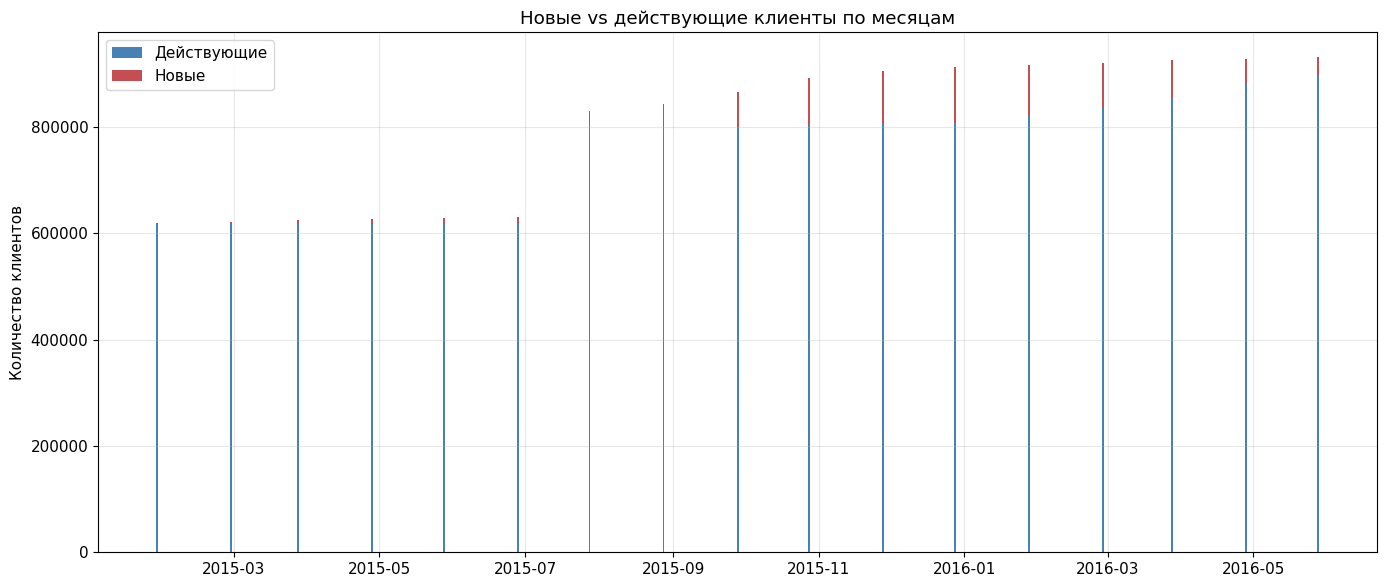

In [45]:
# Новые vs все клиенты
monthly_new = df.groupby('fecha_dato')['ind_nuevo'].sum().reset_index()
monthly_new.columns = ['Месяц', 'Новых']
monthly_new = monthly_new.merge(monthly_clients[['Месяц', 'Клиентов']], on='Месяц')
monthly_new['Старых'] = monthly_new['Клиентов'] - monthly_new['Новых']

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(monthly_new['Месяц'], monthly_new['Старых'], label='Действующие', color='steelblue')
ax.bar(monthly_new['Месяц'], monthly_new['Новых'], bottom=monthly_new['Старых'],
       label='Новые', color='#C44E52')
ax.set_ylabel('Количество клиентов')
ax.set_title('Новые vs действующие клиенты по месяцам')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

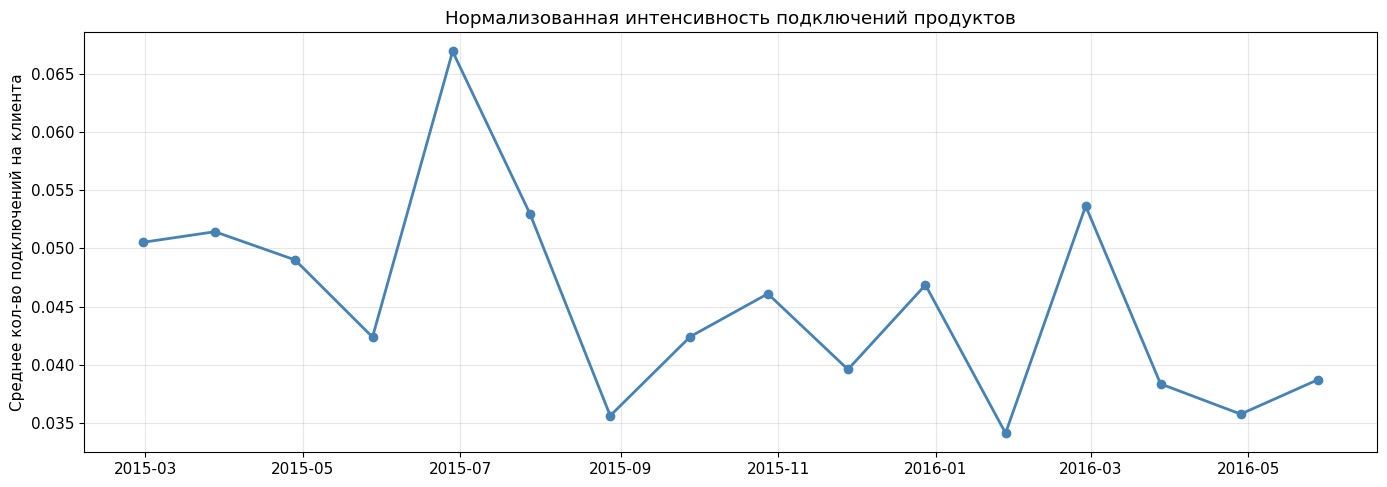

In [46]:
# Нормализованная интенсивность подключений
# (количество переходов 0→1 / количество клиентов в месяце)
monthly_trans_total = transitions_df.groupby('fecha_dato')[new_cols].sum().sum(axis=1)
monthly_n_clients = transitions_df.groupby('fecha_dato').size()

intensity = (monthly_trans_total / monthly_n_clients).reset_index()
intensity.columns = ['Месяц', 'Интенсивность']

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(intensity['Месяц'], intensity['Интенсивность'],
        marker='o', color='steelblue', linewidth=2)
ax.set_ylabel('Среднее кол-во подключений на клиента')
ax.set_title('Нормализованная интенсивность подключений продуктов')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

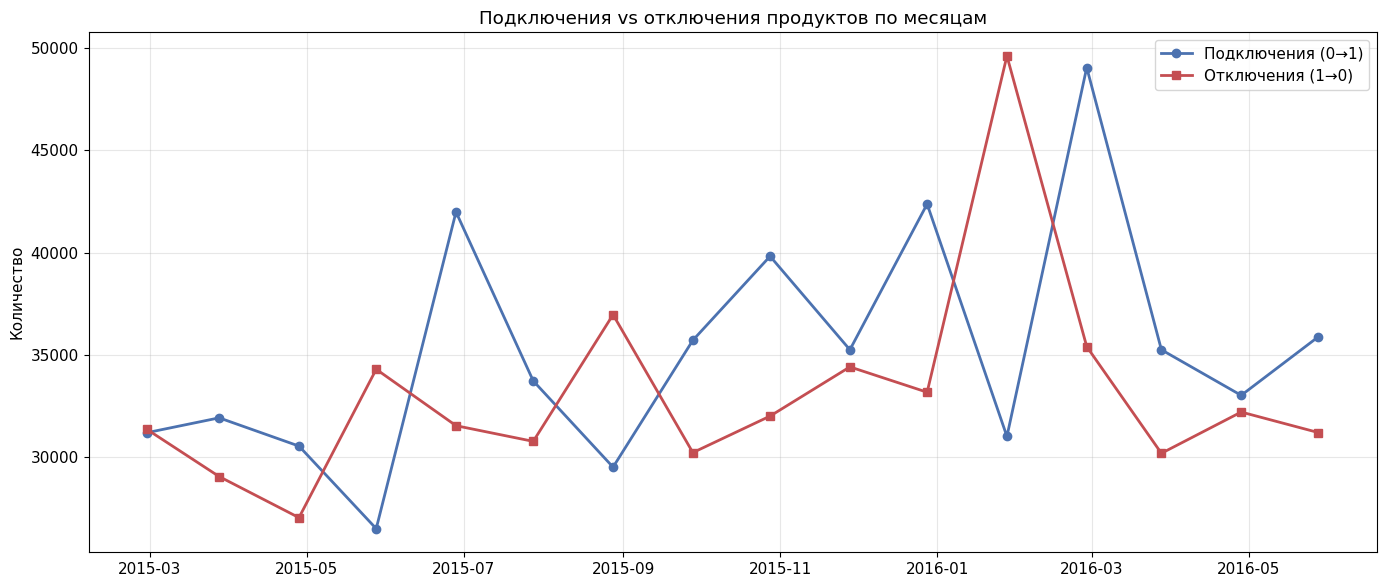

In [47]:
# Подключения vs отключения (0→1 vs 1→0)
disconnections = ((df[PRODUCT_COLS].values == 0) & (prev.values == 1)).astype(np.int8)
disconn_df = pd.DataFrame(disconnections, columns=[f'{c}_disc' for c in PRODUCT_COLS],
                           index=df.index)
disconn_df['fecha_dato'] = df['fecha_dato'].values
disconn_df = disconn_df[prev.notna().any(axis=1)]

disc_cols = [f'{c}_disc' for c in PRODUCT_COLS]
monthly_conn = transitions_df.groupby('fecha_dato')[new_cols].sum().sum(axis=1)
monthly_disc = disconn_df.groupby('fecha_dato')[disc_cols].sum().sum(axis=1)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(monthly_conn.index, monthly_conn.values, marker='o',
        label='Подключения (0→1)', color='#4C72B0', linewidth=2)
ax.plot(monthly_disc.index, monthly_disc.values, marker='s',
        label='Отключения (1→0)', color='#C44E52', linewidth=2)
ax.set_ylabel('Количество')
ax.set_title('Подключения vs отключения продуктов по месяцам')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Выводы и рекомендации для моделирования

### Данные
- Датасет содержит ~13.6 млн записей (ежемесячные срезы) для ~960К уникальных клиентов за 17 месяцев.
- После базовой очистки удалено 683 полностью битых строки и 3 бесполезных колонки (`conyuemp`, `ult_fec_cli_1t`, `tipodom`).
- Основные пропуски: `renta` (~18%), `cod_prov`/`nomprov` (~1.2%), категориальные (<0.5%).

### Качество данных
- `age` и `antiguedad` хранились как строки с пробелами — очищены.
- Есть аномальные возрасты (< 18 и > 100) — требуют внимания при моделировании.
- `renta` имеет сильный правый скос (медиана ~89К, макс ~24М) — рекомендуется log-трансформация.

### Продукты
- **Сильный дисбаланс:** `ind_cco_fin_ult1` (текущие счета) есть у ~90% клиентов, а 8 продуктов — у менее 2% клиентов.
- Два продукта (`ind_ahor_fin_ult1`, `ind_aval_fin_ult1`) имеют близкую к нулю распространённость.
- **Связка:** `ind_nomina_ult1` и `ind_nom_pens_ult1` — корреляция 0.96, часто подключаются вместе.
- Наибольшее число новых подключений: текущие счета, дебетовый аккаунт, зарплатный проект.

### Сегменты
- Подавляющее большинство клиентов — резиденты Испании (99.2%), не сотрудники банка (99.3%).
- Существенные различия по сегментам: VIP-клиенты имеют больше инвестиционных и пенсионных продуктов.
- Возрастная группа 25-44 — ядро по подключениям, 65+ — больше депозитов и пенсионных продуктов.
- Высокодоходные клиенты чаще имеют ценные бумаги, пенсионные планы, ипотеку.

### Временная структура
- Резкий скачок клиентской базы в июле 2015 (прирост ~200К клиентов, +31%).
- Интенсивность подключений продуктов варьируется по месяцам, что важно для валидации.

### Рекомендации для моделирования

1. **Целевая переменная:** переходы 0→1 (клиент подключил новый продукт).
2. **Разбиение:** временное разбиение по `fecha_dato` (не случайное), учитывать скачок в июле 2015.
3. **Подход:** Binary Relevance (отдельная модель на каждый продукт) или единая multi-label модель.
4. **Feature engineering:**
   - Лаг-фичи (какие продукты были в предыдущие месяцы).
   - Количество уже имеющихся продуктов.
   - Изменения в профиле клиента (стал активным/неактивным, сменил сегмент).
   - Log-трансформация `renta`.
   - Группировка редких категорий (`canal_entrada`, `pais_residencia`).
5. **Дисбаланс:** oversampling, class weights, или focus на продуктах с достаточным числом переходов.
6. **Редкие продукты:** `ind_ahor_fin_ult1`, `ind_aval_fin_ult1` могут быть исключены из-за крайне малого числа подключений.
7. **Метрики:** MAP@7 (если Kaggle-формат), F1 (macro/weighted), AUC-ROC.